# COMP1801 Tutorial Week 4 - More Complicated Models, Overfitting and Regularisation

*Dr Peter Soar - 2024/25*

This week we will be expanding on the concept of overfitting we were introduced to last week, exploring how we can mitigate this with data splitting, hyperparameter selection, regularisation and finally revising the general model selection process we should be following when performing supervised learning. But first we will start with a quick look at how to deal with categorical features in our data.

For this tutorial, read through and try to understand the text and code examples I have provided (ask your tutor if you have any questions) and there will be a selection of exercises. Attempt these exercises on your own, but do ask your tutor for help if you get stuck.

##0. Do not forget to import all the Python Libraries being used!

In [30]:
import numpy as np # A useful package for dealing with mathematical processes, we will be using it this week for vectors and matrices
import pandas as pd # A common package for viewing tabular data
import sklearn.linear_model, sklearn.datasets # We want to be able to access the sklearn datasets again, also we are using some model evaluation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder, OneHotEncoder # We will be using the inbuilt preprocessing functions sklearn provides
import matplotlib.pyplot as plt # We will be using Matplotlib for our graphs
from sklearn.model_selection import train_test_split # A library that can automatically perform data splitting for us
from sklearn.linear_model import Ridge, Lasso, LinearRegression # Ridge & Lasso regression are types of linear model that use regularisation
from sklearn.metrics import mean_squared_error, r2_score # Allows us to use the MSE function without calling in sklearn each time
# from google.colab import files # We will be importing a csv file I have provided for one section.
import warnings
warnings.filterwarnings('ignore') # suppresses a convergence warning we may get when testing Lasso - this is just cosmetic to stop too much output.

# 1. Categorical feature data

So far we have only been considering feature columns that have been populated with numerical data, however it is not unusual to encounter datasets where the feature columns may include text values that have some meaning for the target predictions, however these must be converted into a numerical form somehow in order to be used by the machine learning algorithms.

We would call these categorical feature data, and converting these features into numerical values (often called 'feature encoding') is another data preprocessing operation you should be aware of when using tabular data.

##1.1 Loading in dataset

For this problem, I have created a synthetic dataset which I have uploaded to moodle. Please load this csv below.



In [31]:
# uploaded = files.upload()    # Will prompt you to select file
# Your file is now in the Colab filesystem on the left
testData = pd.read_csv('T4-Dataset-1.csv') # Save it to a pandas dataframe

This data shows the final grade of a selection of students from 4 different schools. We have the scored from their previous two mock papers, but there are also a number of categorical feature columns that we can't currently use.

Let's have a look at the data:

In [32]:
# This file has all the data elements constructed already, so we can just put the entire thing into the 'data='
df = pd.DataFrame(data= testData)

# show the data
display(df)

,mock1,mock2,studyTime,travelTime,absence,school,finalGrade
0,67,69,241-480,61-120,No,KCI,100
1,89,87,121-240,31-60,No,KHV,94
2,43,39,241-480,61-120,No,QE2,51
3,94,89,241-480,61-120,Yes,QE2,100
4,7,14,241-480,31-60,Yes,KCI,26
...,...,...,...,...,...,...,...
395,89,83,241-480,31-60,Yes,KCI,100
396,9,8,241-480,61-120,No,QE2,17
397,78,77,241-480,31-60,No,QE2,97
398,22,22,241-480,61-120,No,KCI,61


First, let's see how good a fit we get just using the mock scores, so data that is numerical already.

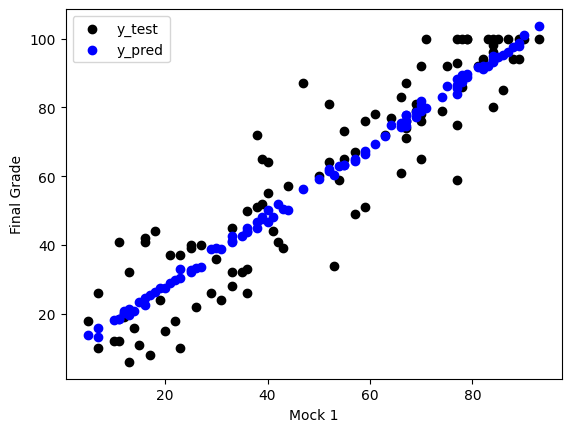

Mean squared error loss: 124.7968
R2 score: 0.8539


In [33]:
col_fin = ['mock1','mock2']
tar = ['finalGrade']
X = np.array(testData[col_fin])
y = np.array(testData[tar])

# Define how much test and training data we want. You can try changing these later to see how it changes the model and predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=0)

# Create linear regression object
obj = sklearn.linear_model.LinearRegression(fit_intercept=True)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_test)

X_test_disp = X_test[:,0] # We will need to make a special vector for the feature we want on the x axis, as now X is a matrix matplotlib can't use it for a scatter plot

# Plot outputs
plt.scatter(X_test_disp, y_test,  color='black', label='y_test') # Observed y values
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('Mock 1')
plt.ylabel('Final Grade')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))

Okay, so around 83% $R^2$ score is a pretty strong baseline, but the categorical columns may be the key to explaining the remaining variation.

## 1.2 Label encoding


Given the original dataset, it is clear we have many categorical features. All these need to be encoded. The [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) class is used to transform the categorical or string values to numerical ones (between 0 and n_classes-1).

In this case we will see what an impact the school has on peoples final grades, as there are 4 schools we should expect this column to be filled with values from '0-3'.

In [34]:
testData_school = testData.copy() # We will be making copies of the dataset as we will be making changes to the columns as we go along

# create an object of the LabelEncoder class
lblEncoder_X = LabelEncoder()
# apply LblEncoder object to our categorical variables (columns - 'school') using the fit_transform method. This returns the column encoded.
testData_school['school'] = lblEncoder_X.fit_transform(testData_school['school'])

print(testData_school) # See that the 'school' column is now filled with integer values matching the 4 schools

     mock1  mock2 studyTime travelTime absence  school  finalGrade
0       67     69   241-480     61-120      No       0         100
1       89     87   121-240      31-60      No       2          94
2       43     39   241-480     61-120      No       3          51
3       94     89   241-480     61-120     Yes       3         100
4        7     14   241-480      31-60     Yes       0          26
..     ...    ...       ...        ...     ...     ...         ...
395     89     83   241-480      31-60     Yes       0         100
396      9      8   241-480     61-120      No       3          17
397     78     77   241-480      31-60      No       3          97
398     22     22   241-480     61-120      No       0          61
399     12     17   241-480      31-60     Yes       3          19

[400 rows x 7 columns]


Now let's try including this new numerical feature in our model.

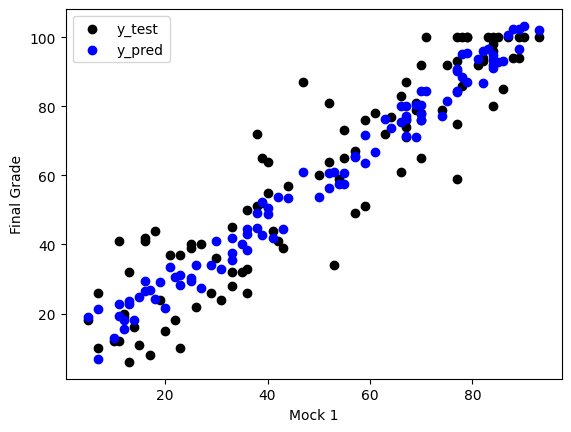

Mean squared error loss: 114.1023
R2 score: 0.8664


In [35]:
tar='finalGrade'
col_fin=['mock1','mock2','school']

X = np.array(testData_school[col_fin])
y = np.array(testData_school[tar])

# Define how much test and training data we want. You can try changing these later to see how it changes the model and predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=0)

# Create linear regression object
obj = sklearn.linear_model.LinearRegression(fit_intercept=True)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_test)

X_test_disp = X_test[:,0] # We will need to make a special vector for the feature we want on the x axis, as now X is a matrix matplotlib can't use it for a scatter plot

# Plot outputs
plt.scatter(X_test_disp, y_test,  color='black', label='y_test') # Observed y values
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('Mock 1')
plt.ylabel('Final Grade')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))

The score has improved, but not by much in this case - but there are still lots of other categorical features we haven't used yet. Let's try looking at the impact of the study time - surely that will have an impact on how well they perform on the test!

,mock1,mock2,studyTime,travelTime,absence,school,finalGrade,studyTime_enc
0,67,69,241-480,61-120,No,KCI,100,2
1,89,87,121-240,31-60,No,KHV,94,1
2,43,39,241-480,61-120,No,QE2,51,2
3,94,89,241-480,61-120,Yes,QE2,100,2
4,7,14,241-480,31-60,Yes,KCI,26,2
...,...,...,...,...,...,...,...,...
395,89,83,241-480,31-60,Yes,KCI,100,2
396,9,8,241-480,61-120,No,QE2,17,2
397,78,77,241-480,31-60,No,QE2,97,2
398,22,22,241-480,61-120,No,KCI,61,2


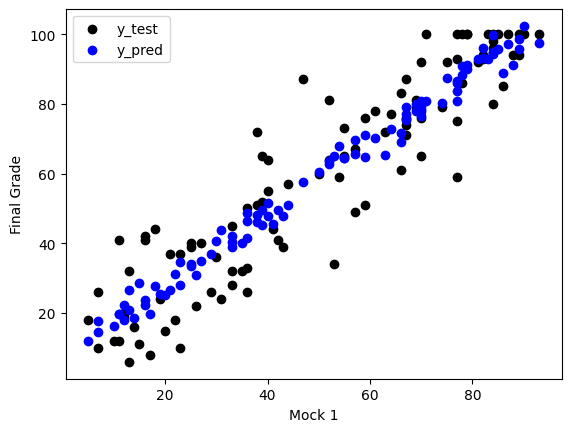

Mean squared error loss: 123.4471
R2 score: 0.8554


In [36]:
testData_studyTime = testData.copy() # We will be making copies of the dataset as we will be making changes to the columns as we go along

# create an object of the LabelEncoder class
lblEncoder_X = LabelEncoder()
# apply LblEncoder object to our categorical variables (columns - 'school') using the fit_transform method. This returns the column encoded.
testData_studyTime['studyTime_enc'] = lblEncoder_X.fit_transform(testData_studyTime['studyTime'])

display(testData_studyTime)

tar='finalGrade'

col_fin=['mock1','mock2','studyTime_enc']


X = np.array(testData_studyTime[col_fin])
y = np.array(testData_studyTime[tar])

# Define how much test and training data we want. You can try changing these later to see how it changes the model and predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=0)

# Create linear regression object
obj = sklearn.linear_model.LinearRegression(fit_intercept=True)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_test)

X_test_disp = X_test[:,0] # We will need to make a special vector for the feature we want on the x axis, as now X is a matrix matplotlib can't use it for a scatter plot

# Plot outputs
plt.scatter(X_test_disp, y_test,  color='black', label='y_test') # Observed y values
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('Mock 1')
plt.ylabel('Final Grade')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))

Except it turns out that this adds even less accuracy than the 'school', with no significant improvement from just using the mocks.

**Question:** Can you work out what has gone wrong to cause this feature to have no impact on the accuracy?

##### **Answer:**



It's because of the ordinal nature being imposed by the label encoding. Now intuitively you would think this is the case where the label coding is appropriate - surely more hours studying is better than less?
I would agree, however if you interrogate the table displayed above, you will notice that the label encoder hasn't assigned values that increment correctly with the increase in time (0: 0-60, 1: 121-240, 2: 241-480, 3:61-120), as the label encoder isn't able to discern the order from the string and just applies the number in the order it first sees them in the dataset, which ruins any pattern that might be in the feature and means in fitting the model this feature is effectively ignored.

This highlights a weakness in label encoding, which could be mitigated by manually converting the columns into representative ordinal numbers, or by employing a different encoding strategy - such as one-hot encoding.

##1.3 One Hot Encoding

The final encoding strategy I'll talk about today is [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder). For each feature, this expands the columns in the dataset to have one column per category using a 0/1 indicator to mark which category corresponds to each data point.

There is no benefit to using OHE for categorical features with only two categories (as you will just end up with two columns where the 1's and 0's are inverted, which adds nothing to the model). So for binary categories always just use label encoding.

Let's try using the `studyTime` feature again to see how different a solution we get when comparing to the label encoding.

If you are going to be using OHE on a larger scale for your data, I would advise setting up a pipeline to streamline things, as in this example I have just manually added all of the encoded columns to our dataframe.

The categories are:  [array(['0-60', '121-240', '241-480', '61-120'], dtype=object)]


,mock1,mock2,studyTime,travelTime,absence,school,finalGrade,studyTime_0,studyTime_1,studyTime_2,studyTime_3
0,67,69,241-480,61-120,No,KCI,100,0.0,0.0,1.0,0.0
1,89,87,121-240,31-60,No,KHV,94,0.0,1.0,0.0,0.0
2,43,39,241-480,61-120,No,QE2,51,0.0,0.0,1.0,0.0
3,94,89,241-480,61-120,Yes,QE2,100,0.0,0.0,1.0,0.0
4,7,14,241-480,31-60,Yes,KCI,26,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
395,89,83,241-480,31-60,Yes,KCI,100,0.0,0.0,1.0,0.0
396,9,8,241-480,61-120,No,QE2,17,0.0,0.0,1.0,0.0
397,78,77,241-480,31-60,No,QE2,97,0.0,0.0,1.0,0.0
398,22,22,241-480,61-120,No,KCI,61,0.0,0.0,1.0,0.0


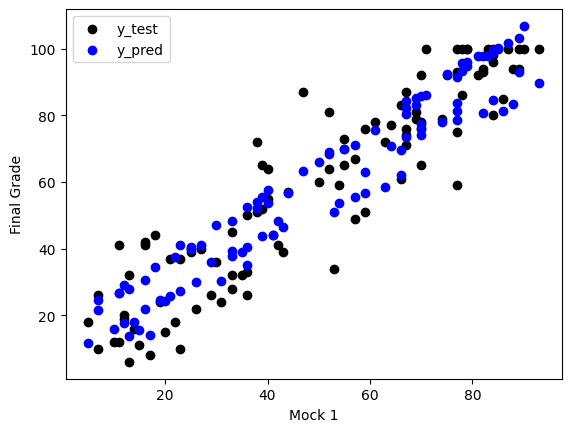

Mean squared error loss: 84.3517
R2 score: 0.9012


In [37]:
# create dataset copy for testing purposes
testDataOHE = testData.copy()

# create OneHotEncoder object
oneHotEncoder = OneHotEncoder()
# and fit the OneHotEncoder object to feature studyTime
onehot_enc = oneHotEncoder.fit(testDataOHE[['studyTime']])
print('The categories are: ', onehot_enc.categories_)

# dum is an array of shape (391,2) containing the one-hot encoding of the feature Gender of the dataframe train_dataset_no_nans
# we make a temporary object to be able to manipulate the extra number of columns
OHT = onehot_enc.transform(testDataOHE[['studyTime']]).toarray()

# we add to the encoded columns to our dataset
testDataOHE['studyTime_0'] = OHT[:,0]
testDataOHE['studyTime_1'] = OHT[:,1]
testDataOHE['studyTime_2'] = OHT[:,2]
testDataOHE['studyTime_3'] = OHT[:,3]

# chack that the new columns correspond to the correct time range (note, they may not be split in order, you can see the order they were split in the print statement above)
display(testDataOHE)

tar='finalGrade'

col_fin=['mock1','mock2','studyTime_0','studyTime_1','studyTime_2','studyTime_3']

X = np.array(testDataOHE[col_fin])
y = np.array(testDataOHE[tar])

# Define how much test and training data we want. You can try changing these later to see how it changes the model and predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=0)

# Create linear regression object
obj = sklearn.linear_model.LinearRegression(fit_intercept=True)

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_test)

X_test_disp = X_test[:,0] # We will need to make a special vector for the feature we want on the x axis, as now X is a matrix matplotlib can't use it for a scatter plot

# Plot outputs
plt.scatter(X_test_disp, y_test,  color='black', label='y_test') # Observed y values
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('Mock 1')
plt.ylabel('Final Grade')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))

Okay, so in this case our one-hot encoded features slightly outperform taking the range average, but it is basically the same accuracy wise.

As is often the case in ML, which method will give you the best results when dealing with categorical data will vary based on your dataset, so it is always worth experimenting with different encoding methods for your categorical data when testing your initial models.

##1.4 Exercise 1

So far we have only looked at two of our categorical features.
Using all of the data, see how accurate a prediction of the final grade you can obtain (I was able to get around 93% $R^2$, but maybe you can do better!)

Some things to try:

*   See how performance changes with different encoding methods for each categorical feature (Label Encoding, One-hot encoding, taking the range average).
*   You can use different encoding methods for different features if appropriate.



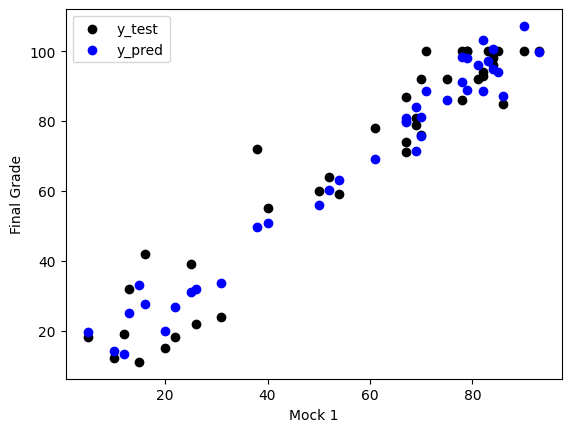

Mean squared error loss: 68.6413
R2 score: 0.9281


In [38]:
##############################################################
# Your code here
##############################################################

# Note: I'm not claiming this is the best solution possible - this is actually quite a 'basic' approach using only multivariable regression with label encoding
# You may be able to improve on this score by exploring different encoding methods!

testData_enc = testData.copy() #note we are using the dataset with no missing values

tar='finalGrade'

# create an object of the LabelEncoder class
lblEncoder_X = LabelEncoder()
testData_enc['studyTime'] = lblEncoder_X.fit_transform(testData_enc['studyTime'])
testData_enc['travelTime'] = lblEncoder_X.fit_transform(testData_enc['travelTime'])
testData_enc['absence'] = lblEncoder_X.fit_transform(testData_enc['absence'])
testData_enc['school'] = lblEncoder_X.fit_transform(testData_enc['school'])

col_fin=['mock1','mock2','studyTime','travelTime','absence','school']

X = np.array(testData_enc[col_fin])
y = np.array(testData_enc[tar])

# Define how much test and training data we want. You can try changing these later to see how it changes the model and predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=0)

# Create linear regression object
obj = sklearn.linear_model.LinearRegression()

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_test)

X_test_disp = X_test[:,0] # We will need to make a special vector for the feature we want on the x axis, as now X is a matrix matplotlib can't use it for a scatter plot

# Plot outputs
plt.scatter(X_test_disp, y_test,  color='black', label='y_test') # Observed y values
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('Mock 1')
plt.ylabel('Final Grade')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))

#2. Data preprocessing and the full ML pipline

## 2.1 Data Pre-processing
As described in the lecture, feature scaling has multiple benefits for our ML implementation, including:
- Evening out the sensitivity of the different parameters to changes
- Making the model more interpretable
- Improving regularisation behaviour
- Improving optimisation behaviour (explained in later weeks)

The two main methods we are currently considering are Standardisation and Normalisation (MinMax Scaling), both of which are easy to apply using sklearn.

**Standardization**

By calculating the mean and variance for our data columns we can scale each feature so that it has a mean of 0 and a variance of 1.
$$x_s = \frac{x-\mu_x}{\sigma_x}$$
We can standardize the data by the `sklearn.preprocessing.StandardScaler` instance.
- Initialization: `StandardScaler` initializer.
- Calculating the mean and variance (standard deviation) by using `fit` with our object and data.
  - Input: the `np.array` instance of which to calculate the mean and variance.
- Apply the standardization using `transform`.

In [39]:
scaler = StandardScaler()
# calculate the mean and variance for each feature and store to attributes
scaler.fit(X_train[:,0:2]) # We only want to perform feature scaling on the numeric (so not categorical) features
print(f'Raw mean = \n{scaler.mean_}, \nRaw var = \n{scaler.var_}') # print the calculated mean and variance for each attribute
X_train_stded = scaler.transform(X_train[:,0:2]) # standardize X_train
# verify that X_train_stded has mean 0 (mean isn't quite 0 due to numerical error, but is a miniscule value) and variance 1.
print(f'Standardised mean = \n{np.mean(X_train_stded, axis=0)}, \nStandardised var = \n{np.var(X_train_stded, axis=0)}')

# Remember to rejoin our scaled features with our categorical features in our final feature matrix
X_train_stded = np.c_[X_train_stded, X_train[:,2:]]
print(X_train_stded)

Raw mean = 
[49.74166667 48.98888889], 
Raw var = 
[612.34715278 615.52765432]
Standardised mean = 
[-1.38777878e-17  8.07995646e-17], 
Standardised var = 
[1. 1.]
[[-0.3936719  -0.03985875  2.          2.          0.          2.        ]
 [-0.79778334 -0.56384461  2.          2.          0.          1.        ]
 [-0.31284961 -0.03985875  1.          1.          0.          1.        ]
 ...
 [ 0.85907358  0.80657994  3.          2.          0.          3.        ]
 [ 0.49537328  0.52443371  1.          1.          1.          0.        ]
 [ 0.81866243  0.64535353  1.          2.          0.          0.        ]]


**Normalisation (MinMax)**

By calculating the maximum and minimum values for our data columns we can scale each feature so that it takes a value between 0 and 1.
$$x_s = \frac{x-x_{min}}{x_{max}-x_{min}}$$
We can standardize the data by the `sklearn.preprocessing.MinMaxScaler` instance.
- Initialization: `MinMaxScaler` initializer.
- Calculating the min and max of the feature by using `fit` with our object and data.
  - Input: the `np.array` instance of which to calculate the mean and variance.
- Apply the standardization using `transform`.

In [40]:
scaler = MinMaxScaler()
# calculate the mean and variance for each feature and store to attributes
scaler.fit(X_train[:,0:2]) # We only want to perform feature scaling on the numeric (so not categorical) features
print(f'Raw min = \n{np.min(X_train[:,0:2], axis=0)}, \nRaw max = \n{np.max(X_train[:,0:2], axis=0)}') # print the calculated mina and max for each attribute
X_train_stded = scaler.transform(X_train[:,0:2]) # standardize X_train
# verify that X_train_stded has min 0 and max 1.
print(f'Normalised Min = \n{np.min(X_train_stded, axis=0)}, \nNormalised Max = \n{np.max(X_train_stded, axis=0)}')

# Remember to rejoin our scaled features with our categorical features in our final feature matrix
X_train_stded = np.c_[X_train_stded, X_train[:,2:]]
print(X_train_stded)

Raw min = 
[5 0], 
Raw max = 
[ 95 100]
Normalised Min = 
[0. 0.], 
Normalised Max = 
[1. 1.]
[[0.38888889 0.48       2.         2.         0.         2.        ]
 [0.27777778 0.35       2.         2.         0.         1.        ]
 [0.41111111 0.48       1.         1.         0.         1.        ]
 ...
 [0.73333333 0.69       3.         2.         0.         3.        ]
 [0.63333333 0.62       1.         1.         1.         0.        ]
 [0.72222222 0.65       1.         2.         0.         0.        ]]


For most of our case we will apply standardisation, which is generally a better choice for unbounded data like we are using. However MinMax scaling is a valid approach that can be useful when we have a bounded numerical column (for example if we know all values are in a range of 0-100). It is possible that you may want to perform different feature scaling operations on different features depending on the type of data being stored.

Note: Remember that we should generally not perform feature scaling on our categorical features. Though this can cause practical difficulties when implementing polynomial interactions between categorical and numerical columns or big data implementation with many columns of different data types.

##2.2 Data Splitting

So far in our models we have been splitting our data into two sections - training data and test data. However, until this week I have not really explained the rationale behind this in detail, and in fact splitting our data into three groups is generally preferable for a robust ML pipeline.

To begin with, let us load in our California Housing data (staying univariate for now to keep things simple) and convert it to arrays as we usually do:

In [41]:
# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)
Xy_df = pd.concat([X_pd, y_pd], axis=1)

# Use only one feature
col = 'MedInc'
Xy_df = Xy_df[['MedInc', 'MedHouseVal']]

# show the data
display(Xy_df)

# Convert the data to `np.array`
X_raw = np.array(X_pd[['MedInc']])
y = np.array(y_pd)


,MedInc,MedHouseVal
0,8.3252,4.526
1,8.3014,3.585
2,7.2574,3.521
3,5.6431,3.413
4,3.8462,3.422
...,...,...
20635,1.5603,0.781
20636,2.5568,0.771
20637,1.7000,0.923
20638,1.8672,0.847


As we have been exploring over the last few weeks, when optimising parameters, selecting a model, and tuning hyperparameters, **overfitting** happens.
Hence, we need a set of data for optimising our model parameters (training) and an additional set (validation) where we compare the performance of multiple models and hyperparameters to help us decide what our optimal Machine Learning model is for a given dataset. However, we still need to perform a final evaluation of this model using a final set of data (testing) that hasn't been used in either of these prior steps. It may seem counter-intuitive, but even though the validation dataset is not used to train the model parameters directly, we can still end up overfitting the validation data to a degree as we pick the model and hyperparameters which perfoms the best in the validation stage.

In brief - we split the feature/target pairs into the following three datasets:
- **Training data** for optimising parameters.
- **Validation data** for selecting a model and tuning hyperparameters.
- **Test data** for evaluating the true performance of your best model(s)

The exact proportion of training:validation:testing data does not follow exact rules, and may depend on how much data you have available (if you do not have much data, you may not want to use too much test and validate as you may be missing out on information from the features). I would say that as a rule of thumb anywhere between 60%:20%:20% and 80%:10%:10% is an easily justifiable split (ideally keeping the validation and test datasets both using the same proportion).

Strictly speaking, once you split the test data from others, we can adopt a more complicated way to optimise parameters and select a model and tune hyperparameters. The above splitting strategy is one of the simplest way, but widely used. Another widely used example is [**cross validation**](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation), where we split the non-test data multiple times. There is more detail on this in Appendix 1, and while not required to do well in your coursework it is a powerful and widely used approach to consistent data splitting results that you may want to consider exploring.

From now on we will split the data using two rounds of the `sklearn.model_selection.train_test_split` function. A reminder, we must ensure we use the correct data shuffle setting.
- For non time series data, usually, **we should shuffle** the data by specifying **`shuffle=True`** to avoid the bias of the data by data index.
- For time series data, we **must NOT shuffle** the data to chronologically split the data into training/validation/test data. Specifically, the training data must be earlier data than the other two, and the validation data must be earlier than the test data. In this way, we can simulate the real application, where we handle the latest data.


In [42]:
# Split the data into non-test/test data
# While we have 20640 pairs of a feature and target, we use 20% only for the testing, not so we hold back the other 80% for training and validation
# `shuffle=True` for non-time series case. You should set `shuffle=False` for time series data to avoid future data being contaminated in the training data.
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)

# Split the non-test data into non-test/test data
# We use 25% of the remaining non-test data only for the validation set, leaving the rest for training
# In the end, the splitting ratio will be 6:2:2 for the training, validation, and test data.
# `shuffle=True` for non-time series case. You should set `shuffle=False` for time series data to avoid future data being contaminated in the training data.
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

Preprocessing reminder (e.g. polynomial features and standardisation/normalisation):

Validation data and test data are both used to simulate new data we are using in the prediction stage. Hence, similar to what we learnt in previous weeks, machine learning prediction models require the features in the training data, validation data, test data (the data on which we predict) to all be preprocessed **the same way**.

For example, we must use the mean and standard deviation **of the training data** for standardizing **both the training data and the new data**.
If we fit a new preprocessing object on our new data then we would obtain different values for the mean an standard deviation such that after preprocessing the same value in the training data and new data would become different in both datasets after preprocessing, confusing our ML model and almost certainly leading to useless predictions.

Hence, we fit the preprocessor to **the training data only**, and use this to transform **both the training data and the new data** (where by *new* data we mean our validation data, test data and any truly *new* data encountered when deploying our ML solution in the real world).

## 2.3 Full ML pipline

I have discussed this in the lecture, but below I would just like to repeat the full Machine Learning pipeline we should be following when fitting any supervised learning models for your easy reference (remember that this all also applies to classification models and even the Neural Network models we will be using in later weeks).

Note: Ensure you understand the distinction between a `fit` command using the preprocessor (e.g., `sklearn.preprocessing.StandardScaler`) vs your predictive model (e.g., `sklearn.linear_model.LinearRegression`).

General pipeline:
- Data loading
  - Ensure you perform and Exploratory Data Analysis (EDA) and clean your data before going any further when dealing with real data.
  - Convert your data into arrays that your ML model can interface with.
  - Split your data into the Train:Validation:Test sets.
- Initialization
  - Initialize the preprocessor(s) and the machine learning model objects.
- Model Selection
  - Identify the different solutions you want to try: this could involve different model types (e.g. Linear Regression, Lasso, Ridge, Decision tree, Neural Network, etc), preprocessing methods, feature selection/engineering and hyperparameter selection.
  - Training (do this for **all** models and hyperparameters)
    - **Fit the preprocessor(s)** to the raw training feature matrix.
    - **Transform (Preprocess)** the raw training feature matrix into the preprocessed training feature matrix.
    - **Fit (Train) the prediction model** using the data pair of the preprocessed training feature matrix and target column vector.
    - Recording the performance of the prediction on training data is often also helpful for identifying overfitting.

  - Validation (for **all** models and hyperparameters)
    - **Transform (Preprocess)** the raw validation feature matrix into the preprocessed validation feature matrix using **the preprocessor(s)** (**Do NOT fit any preprocessor to the validation feature matrix**).
    - **Predict** using the preprocessed validation feature matrix to get a predicted target column.
    - **Evaluate** the prediction performance on the validation data by a loss and/or score function.

  - Continue training and validation until you have a model (or selection of models) you feel are potentially good enough to offer a robust solution to the provided prediction problem.

- Test (for the model and hyperparameters selected by the validation process)
  - **Transform (Preprocess)** the raw test feature matrix into the preprocessed test feature matrix by **the preprocessor(s)** (**Do NOT fit any preprocessor to the test feature matrix**).
  - **Predict** on the preprocessed test feature matrix to get a predicted target column.
  - **Evaluate** the prediction performance on the test data by a loss and/or score function.

If after the test step your model is not providing good enough solutions on the test data, then you will have to go back to rethink how you can create a more robust solution less prone to overfitting.


#3. Hyperparameter selection

Choosing appropriate hyperparameters is one of the reasons we need to include the validation step.

A hyperparameter are parameters that dictates how the model behaves, but are not directly related to any of our features in the data. The main hyperparameter we have encountered so far is the degree of our polynomial regression, but the regularisation weight I have talked about in the lecture (and we will see in the next section) is another example. When I talk to you about Neural Networks in a few weeks we will have even more of these - such as the learning rate, number of epochs and even the number of hidden layers.

Systemically selecting hyperparmaters is very important to obtaining a good ML solution, and while we could always just try varying these by hand this is slow and you need to make sure you keep detailed records of the results. It is far more robust to set up a pipeline to test a range of values for us and provide us with the setup that gives us the lowest Mean Squared Error.

Experimentation is key to obtaining the best results, so ensure you demonstrate you have setup a framework for selecting the best hyperparamters whenever you are making a model recommendation.

##3.1 Hyperparameter Selection Example: Polynomial Regression.

Reminder from last week:

Using [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial#sklearn.preprocessing.PolynomialFeatures) is another preprocessing step, and is very similar to the feature scaling in implementation.

- Initialize the polynomial features object.
  - Method: `PolynomialFeatures(degree)`
  - Input parameter: Maximum polynomial degree you want for your model (this is really a hyperparameter we need to choose carefully, but we will cover how to best pick this degree next week).
- Output: Creates a new feature matrix with polynomial features.
  - Method: `poly.fit_transform`

In this section I will show you how we can select the best degree of polynomial features for the California housing data we loaded in and split above.

Note: The order of the preprocessing steps matters and will change the results - generally it is better to create the polynomial features first then apply standardisation, especially when we have multiple features (see Rule #2 at [this link](https://samchaaa.medium.com/preprocessing-why-you-should-generate-polynomial-features-first-before-standardizing-892b4326a91d)).

First, let's just fit a basic model of a fixed degree to remind you of the full process (make sure you read the comments to understand what we are doing and how this fits into our ML pipeline):

MSE on training data: 0.672068841058383
MSE on validation data: 0.6967282562656024


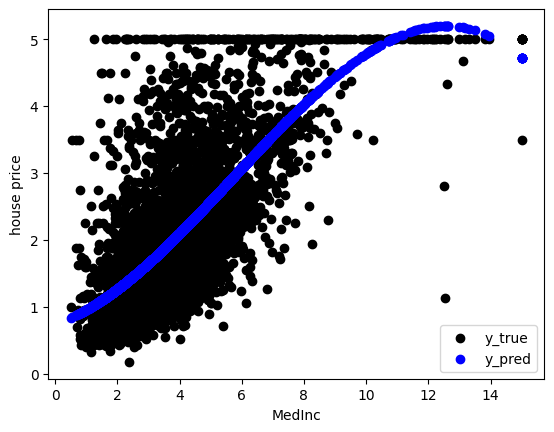

In [43]:
################
# Initialisation
################
model = sklearn.linear_model.LinearRegression() # Create our prediction model object
poly = PolynomialFeatures(degree=3) # Create our Polynomial Features object, here taking a fixed degree of 3
scaler = StandardScaler() # Here is our standardisation object

##########
# Training
##########
# Create Polynomial features BEFORE standardisation
poly.fit(X_train_raw) # Fit polynomial features on our raw training data
X_train_poly = poly.transform(X_train_raw) # transform our raw data using the poly object

scaler.fit(X_train_poly) # Fit the standardisation object on the polynomial feature matrix
X_train = scaler.transform(X_train_poly) # Standardise the feature matrix to get our 'final' training data feature matrix

model.fit(X_train, y_train) # fit our linear regression model - 'train' the model

# Evaluate performance of the training data
# This does NOT reflect the true performance of the model, but keeping track of the training data performance is helpful for checking how much the model is suffering from overfitting.
y_pred_train = model.predict(X_train) # Use our fitted linear regression model to make a prediction
mse_train = mean_squared_error(y_train, y_pred_train) # Calculate the Mean Squared Error for our training data predictions
print('MSE on training data:', mse_train)

############
# Validation
############

# Preprocess validation dataset using preprocessor objects for on the training data
# Do NOT refit the preprocessors
# Create Polynomial features BEFORE standardisation
X_valid_poly = poly.transform(X_valid_raw) # Add polynomial features to the validation data
X_valid = scaler.transform(X_valid_poly) # Standardise the validation data

# We select the best hyperparameters based on the performance of our model on the validation dataset
y_pred_valid = model.predict(X_valid) # Use our fitted linear regression model to make a prediction based on the validation dataset
mse_valid = mean_squared_error(y_valid, y_pred_valid)  # Calculate the Mean Squared Error for our validation data predictions
print('MSE on validation data:', mse_valid)

# Let's just plot our outputs to see how our model is looking
plt.scatter(X_valid_raw, y_valid,  color='black', label='y_true') # Observed y values
plt.scatter(X_valid_raw, y_pred_valid, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()


Okay, so from this we've seen that a polynomial degree of 3 behaves similarly for both our training and validation data - but is this the best degrees to pick?

Rather than varying this hyperparameter manually, we want to set up a framework to automate this for us.

In the following we run a `for` loop incrementing the hyperparameter variable `degree`, applying polynomial regression and storing the MSE for the training and validation data in an array.

In [44]:
max_degree = 30 #Define the max degree to test
# Initialise the MSE arrays, filling them with NaN's
mse_train_array = np.full([max_degree + 1], np.nan)
mse_valid_array = np.full([max_degree + 1], np.nan)
degrees = range(1, max_degree+1) # create list of degree values being iterated through

for degree in degrees:

  # Initialise
  model = sklearn.linear_model.LinearRegression()
  poly = PolynomialFeatures(degree=degree)
  scaler = StandardScaler()
  # Train
  poly.fit(X_train_raw)
  X_train_poly = poly.transform(X_train_raw)
  scaler.fit(X_train_poly)
  X_train = scaler.transform(X_train_poly)
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validate
  X_valid_poly = poly.transform(X_valid_raw)
  X_valid = scaler.transform(X_valid_poly)
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSE for this degree value
  mse_train_array[degree] = mse_train
  mse_valid_array[degree] = mse_valid

Run the cell below to visualise the learning curves from fitting all of these models. You can see that the MSE on the training data monotonously decreases as we use higher degree polynomials (i.e. when using more complex models). As we saw last week, the more complex a model is, the better it can fit training data.

However, the MSE on the validation data starts to increase around `degree=9`  onwards. This shows the overfitting effect. At the beginning of the plot where we have a small `degree` and both the training MSE and validation MSE are high (around `degree = 0-6`) we are seeing underfitting.

We now have the data we need to choose the best degree for our data, as we want to use whichever degree minimises the **validation** MSE, in this case taking `degree = 8`.

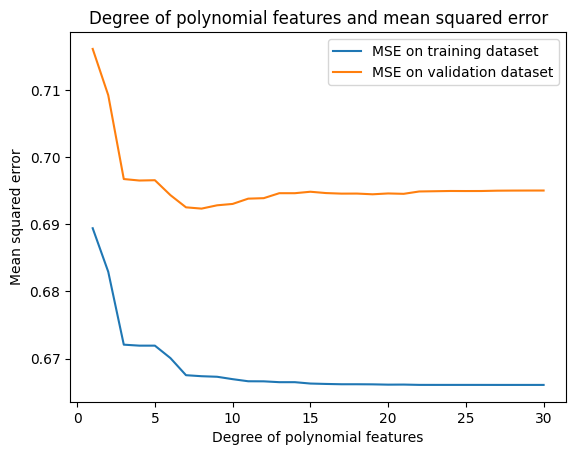

The best degree of polynomials: 8


In [45]:
plt.plot(degrees, mse_train_array[1:], label='MSE on training dataset')
plt.plot(degrees, mse_valid_array[1:], label='MSE on validation dataset')
plt.xlabel('Degree of polynomial features')
plt.ylabel('Mean squared error')
plt.title('Degree of polynomial features and mean squared error')
plt.legend()
plt.show()

best_degree = np.nanargmin(mse_valid_array) # Finds the smallest VALIDATION MSE in the array (ignoring any NaN values).
print('The best degree of polynomials:', best_degree)

Finally, now we have selected the best hyperparameter (degree) on the validation data we now think we have our best model for the data. However, it is possible that the model with the selected hyperparameter is actually overfitting the validation data. To check the true performance of our ML model, we must measure the MSE on the test data.

MSE on the train data: 0.6673713554593006
MSE on the valid data: 0.6923255771563476
MSE on the test data: 0.7021181583023314


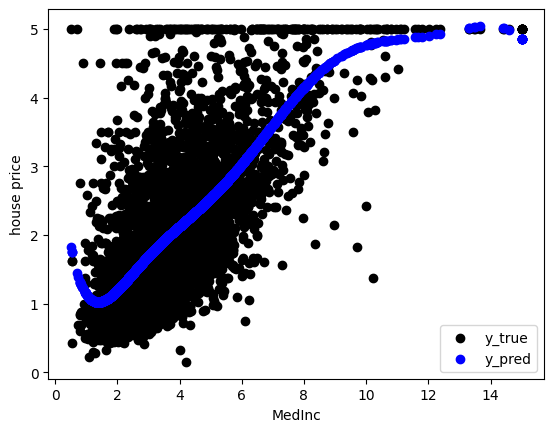

R2 score: 0.4615


In [46]:
# Initialise the test instances
model = sklearn.linear_model.LinearRegression()
poly = PolynomialFeatures(degree=best_degree) # use the degree we selected above
scaler = StandardScaler()

# Remember we have to fit our preprocessors and model on the training data again, as we were using many other degrees in our parametric test above
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
model.fit(X_train, y_train)

mse_train = mean_squared_error(y_train, model.predict(X_train))
print('MSE on the train data:', mse_train) # Get our MSE for the training Data for comparison


X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)
mse_valid = mean_squared_error(y_valid, model.predict(X_valid))
print('MSE on the valid data:', mse_valid) # Get our MSE for the validation Data for comparison

# Now we have fit our preprocessors using the correct degree, we can process our test data and make a prdiction
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print('MSE on the test data:', mse_test) # check our testing MSE, is it signficantly different from our validation MSE?

# Let's just plot our outputs to see how our model is looking
plt.scatter(X_test_raw, y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw, y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()


# Finally, let's also get the R2 score for our final model
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))

So, for this case we can be confident we are not overfitting the validation dataset, with a very similar MSE value to what we observed for `degree=8` during validation.

##3.2 Exercise 2

Use the pipeline outlined above for `degree` selection to find the best polynomial degree for multivariable model for the California housing dataset to see how accurate a final model you can obtain. What do you notice as you include more features and higher polynomial degrees?

Note:
*   Try to use the automated degree selection from above to avoid picking degree values manually like we did last week!
*   Experiment with adding/removing features one at a time by hand, how does this change the result? (we will address removing this chore in the next section). What about changing the amount of training data?
*   Be careful if you are using the full dataset with many features - google Colab may take a long time fitting models with large numbers of polynomial features, if your code is taking too long to run consider lowering the `max_degree` or lowering the size of the sample/number of features being used.

degree: 1, Validation mean squared error: 0.5479495046374266.
degree: 2, Validation mean squared error: 0.503622718874702.
degree: 3, Validation mean squared error: 0.4759894453027306.
degree: 4, Validation mean squared error: 0.44797675023488853.
degree: 5, Validation mean squared error: 0.42211289782657824.
degree: 6, Validation mean squared error: 0.42131120951135337.
degree: 7, Validation mean squared error: 0.4459065451244075.
degree: 8, Validation mean squared error: 0.5454010071346476.


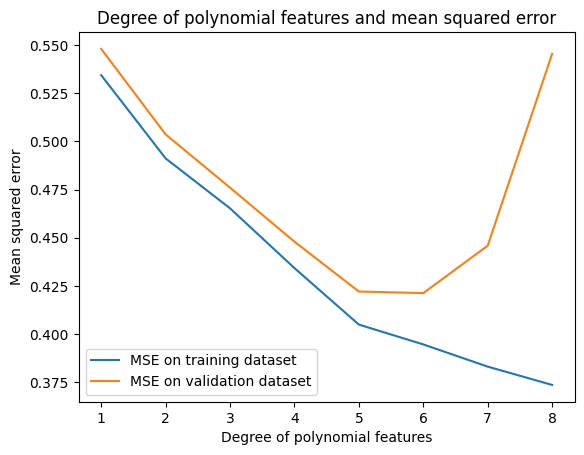

The best degree of polynomials: 6
MSE on the test data: 0.419591420177038


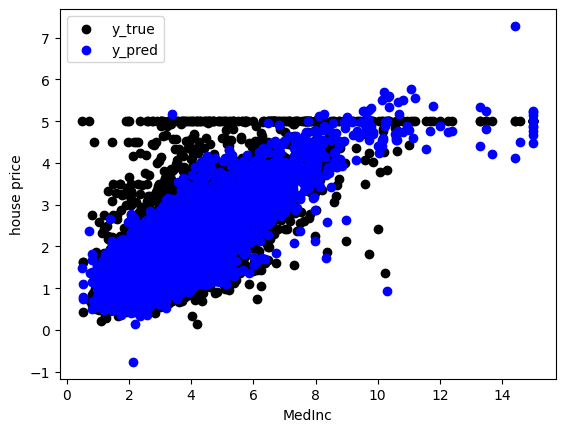

R2 score: 0.6782


In [47]:
##############################################################
# Your code here
##############################################################
# Solution 1 - feature selection
# One thing you can try is adding and removing features. If you can remove a
# feature and your accuracy does not change significantly then your model is
# going to be more robust to unusual observations.

# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# choose features
col = ['MedInc', 'HouseAge', 'Latitude', 'Longitude']
#col = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']# Our full feature set

# Convert the data to `np.array`
X_raw = np.array(X_pd[col])
y = np.array(y_pd)


# Split the data
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

max_degree = 8 #Define the max degree to test
# Initialise the MSE arrays, filling them with NaN's
mse_train_array = np.full([max_degree + 1], np.nan)
mse_valid_array = np.full([max_degree + 1], np.nan)
degrees = range(1, max_degree+1) # create list of degree values being iterated through

for degree in degrees:

  # Initialise
  model = sklearn.linear_model.LinearRegression()
  poly = PolynomialFeatures(degree=degree, interaction_only=False)
  scaler = StandardScaler()
  # Train
  poly.fit(X_train_raw)
  X_train_poly = poly.transform(X_train_raw)
  scaler.fit(X_train_poly)
  X_train = scaler.transform(X_train_poly)
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validate
  X_valid_poly = poly.transform(X_valid_raw)
  X_valid = scaler.transform(X_valid_poly)
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSE for this degree value
  mse_train_array[degree] = mse_train
  mse_valid_array[degree] = mse_valid

  print(f'degree: {degree}, Validation mean squared error: {mse_valid}.')

plt.plot(degrees, mse_train_array[1:], label='MSE on training dataset')
plt.plot(degrees, mse_valid_array[1:], label='MSE on validation dataset')
plt.xlabel('Degree of polynomial features')
plt.ylabel('Mean squared error')
plt.title('Degree of polynomial features and mean squared error')
plt.legend()
plt.show()

best_degree = np.nanargmin(mse_valid_array) # Finds the smallest VALIDATION MSE in the array (ignoring any NaN values).
print('The best degree of polynomials:', best_degree)

# Initialise the test instances
model = sklearn.linear_model.LinearRegression()
poly = PolynomialFeatures(degree=best_degree, interaction_only=False) # use the degree we selected above
scaler = StandardScaler()

# Remember we have to fit our preprocessors and model on the training data again, as we were using many other degrees in our parametric test above
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
model.fit(X_train, y_train)

# Now we have fit our preprocessors using the correct degree, we can process our test data and make a prediction
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test) # check our testing MSE, is it significantly different from our validation MSE?

# Let's just plot our outputs to see how our model is looking
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))

degree: 1, Validation mean squared error: 0.5162416586408561.
degree: 2, Validation mean squared error: 0.42612432178318094.
degree: 3, Validation mean squared error: 0.41280214512026636.
degree: 4, Validation mean squared error: 1.0909321463013477.
degree: 5, Validation mean squared error: 26.89631587981585.


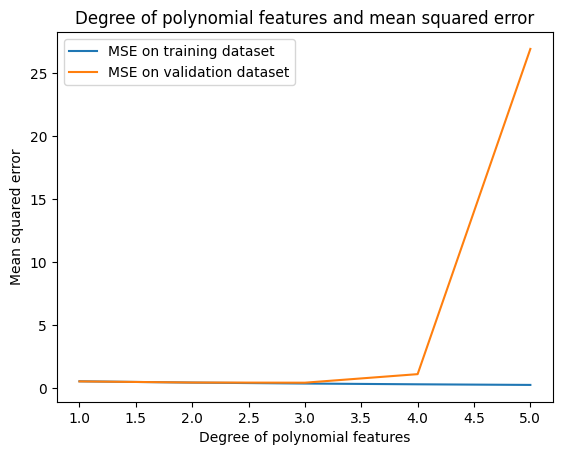

The best degree of polynomials: 3
MSE on the test data: 0.3958890316005631


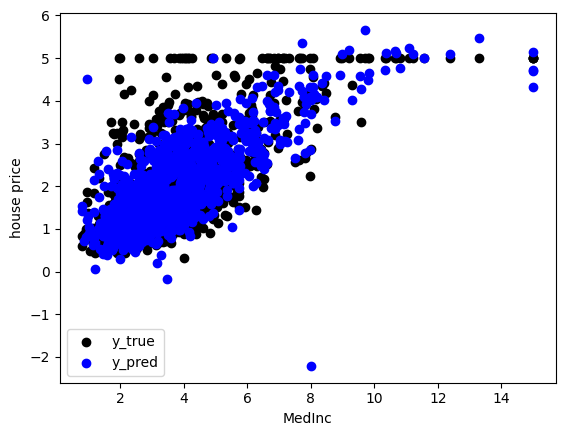

R2 score: 0.7189


In [48]:
##############################################################
# Your code here
##############################################################
# Solution 2 - More training data
# Polynomial features can be very sensitive to unusual data observations, so it
# can help to have as much training data as you can get away with (while still
# having a robust sample to test on - in this case we have around 1000, which
# I think is fine).

# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# choose features
col = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']# prepare NumPy ndarrays

# Convert the data to `np.array`
X_raw = np.array(X_pd[col])
y = np.array(y_pd)


# Split the data
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=1/20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=1/19, shuffle=True, random_state=0)

max_degree = 5 #Define the max degree to test
# Initialise the MSE arrays, filling them with NaN's
mse_train_array = np.full([max_degree + 1], np.nan)
mse_valid_array = np.full([max_degree + 1], np.nan)
degrees = range(1, max_degree+1) # create list of degree values being iterated through

for degree in degrees:

  # Initialise
  model = sklearn.linear_model.LinearRegression()
  poly = PolynomialFeatures(degree=degree, interaction_only=False)
  scaler = StandardScaler()
  # Train
  poly.fit(X_train_raw)
  X_train_poly = poly.transform(X_train_raw)
  scaler.fit(X_train_poly)
  X_train = scaler.transform(X_train_poly)
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validate
  X_valid_poly = poly.transform(X_valid_raw)
  X_valid = scaler.transform(X_valid_poly)
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSE for this degree value
  mse_train_array[degree] = mse_train
  mse_valid_array[degree] = mse_valid

  print(f'degree: {degree}, Validation mean squared error: {mse_valid}.')

plt.plot(degrees, mse_train_array[1:], label='MSE on training dataset')
plt.plot(degrees, mse_valid_array[1:], label='MSE on validation dataset')
plt.xlabel('Degree of polynomial features')
plt.ylabel('Mean squared error')
plt.title('Degree of polynomial features and mean squared error')
plt.legend()
plt.show()

best_degree = np.nanargmin(mse_valid_array) # Finds the smallest VALIDATION MSE in the array (ignoring any NaN values).
print('The best degree of polynomials:', best_degree)

# Initialise the test instances
model = sklearn.linear_model.LinearRegression()
poly = PolynomialFeatures(degree=best_degree, interaction_only=False) # use the degree we selected above
scaler = StandardScaler()

# Remember we have to fit our preprocessors and model on the training data again, as we were using many other degrees in our parametric test above
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
model.fit(X_train, y_train)

# Now we have fit our preprocessors using the correct degree, we can process our test data and make a prediction
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test) # check our testing MSE, is it signficantly different from our validation MSE?

# Let's just plot our outputs to see how our model is looking
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))

#4. Regularization
Instead of manually selecting a model from numerous candidates, regularization can be used to help control the model complexity by lowering the parameter values automatically to weigh against unhelpful parameters. While this process isn't perfect, and can still lead to overfitting the validation data, it does present an easy way of including large numbers of features in your model without painstakingly adding and removing individual features manually.

The strength of the regularization can be regarded as a hyperparameter. Hence, we apply the same pipeline as we did for polynomial degree selection.

##4.1 Example: Ridge regression (linear regression with $\ell^2$ regularization)
Linear regression with the $\ell^2$ regularization term is called Ridge regression. This is just one basic form of a model utilising regularisation, essentially following the same process as our other linear models, but with a differently defined cost function being minimised.

The cost function of the ridge regression is given as follows:
$$
J_{\alpha} (\boldsymbol{\theta}) = L (\boldsymbol{\theta}) + R_{\alpha} (\boldsymbol{\theta}),
$$
where
$$
L (\boldsymbol{\theta})
=
\frac{1}{m} \sum_{i=0}^{m-1} (y^{(i)} - {\boldsymbol{x}^{(i)}}^{\top} \boldsymbol{\theta})^{2},
$$
and
$$
R_{\alpha} (\boldsymbol{\theta})
=
\frac{\alpha}{m} \sum_{j=1}^{n-1} (\theta_{j})^2.
$$

Here,
- $L$ is the loss function that gives the mean squared error,
- $R_{\alpha}$ is the regularization function that gives a $\ell^2$ regularization term,
- $\alpha > 0$ is the regularization weight.

  - If $\alpha$ is large, the regularization is strong, and overfitting is strongly avoided, but may cause underfitting.
  - If $\alpha$ is small, the regularization is weak. In this case the model is close to the original model, so it will not prevent any overfitting.

We can implement the ridge regression model by a `sklearn.linear_model.RidgeRegression` instance.
The regularization weight is specified by the parameter `alpha`, which corresponds to $\alpha$, in the initializer of the `RidgeRegression` class.

### 4.1.1 Ridge regression with a fixed $\alpha$

First, let's just fit a basic Ridge regression instance with a regularisation weight $\alpha$ we have chosen. Let's use a polynomial degree of 30 for this case. This follows the same process as earlier models, but now we are defining out `Ridge` model and `alpha` values as well.

MSE on training data: 0.6718172361315132
MSE on validation data: 0.6954737324202921
MSE on the test data: 0.707767942221258


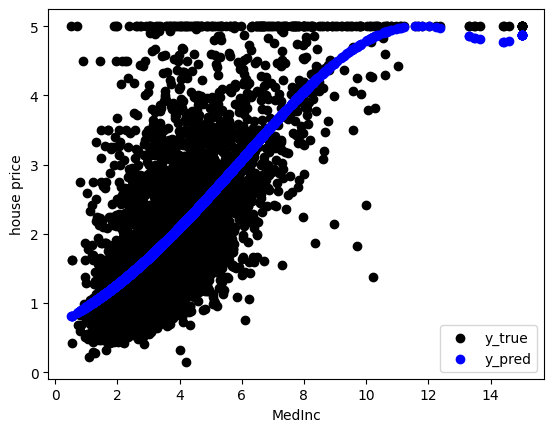

R2 score: 0.4572


In [49]:
# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# Convert the data to `np.array`
X_raw = np.array(X_pd[['MedInc']])
y = np.array(y_pd)

# Split the data
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

# Initialise

# Hyperparameters
alpha = 1
degree = 10

# Initialise Model and preprocessors
model = Ridge(alpha=alpha)
poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

# Train
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
model.fit(X_train, y_train) # note, we fit our ridge model exactly the same as our linear models
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)

# Validate
X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)
y_pred_valid = model.predict(X_valid)
mse_valid = mean_squared_error(y_valid, y_pred_valid)

print('MSE on training data:', mse_train)
print('MSE on validation data:', mse_valid)

# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)

# Predict test data
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test)

# Plot outputs
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))


This seems to be giving us a decent fit to the data already without overfitting, but this is just from arbitrarily picking a regularisation rate. We can actually treat this as a hyperparameter, which means we can implement the same framework used above for polynomial degree to pick the best value for $\alpha$.

###4.1.2 Choosing best $\alpha$ for ridge regression

This is a very similar pipeline to that done above for polynomial degree.
However, unlike the from the previous polynomial case, the preprocessing is the same regardless of the regularization weight (our feature matrix never changes regardless of the regularisation). Hence, we preprocess the training and validation data before the `for` loop. You can focus on the training and evaluating MSE in the `for` loop.

Note: When doing regularisation, we don't need to select the best polynomial degree per se - the regularisation term will in effect account for that to some extent by weighting against unhelpful parameters. However, this does mean that we may have many features in our dataset that are useless, yet are still taking up space/slowing down the fitting processes. I would recommend starting with a relatively small degree and try increasing it if the fitting isn't taking too long.

alpha: 1e-10, Validation mean squared error: 0.692965201717298.
alpha: 1e-09, Validation mean squared error: 0.6927739929811931.
alpha: 1e-08, Validation mean squared error: 0.6926435479352135.
alpha: 1e-07, Validation mean squared error: 0.69264604613526.
alpha: 1e-06, Validation mean squared error: 0.6926692671782992.
alpha: 1e-05, Validation mean squared error: 0.6925895684246335.
alpha: 0.0001, Validation mean squared error: 0.6928534856806786.
alpha: 0.001, Validation mean squared error: 0.6932616923736836.
alpha: 0.01, Validation mean squared error: 0.6946462485951768.
alpha: 0.1, Validation mean squared error: 0.6953950600809787.
alpha: 1.0, Validation mean squared error: 0.6954737324202921.
alpha: 10.0, Validation mean squared error: 0.695542511544742.
alpha: 100.0, Validation mean squared error: 0.6966659210845121.
alpha: 1000.0, Validation mean squared error: 0.704291661187823.
alpha: 10000.0, Validation mean squared error: 0.7809573079490039.
alpha: 100000.0, Validation mean

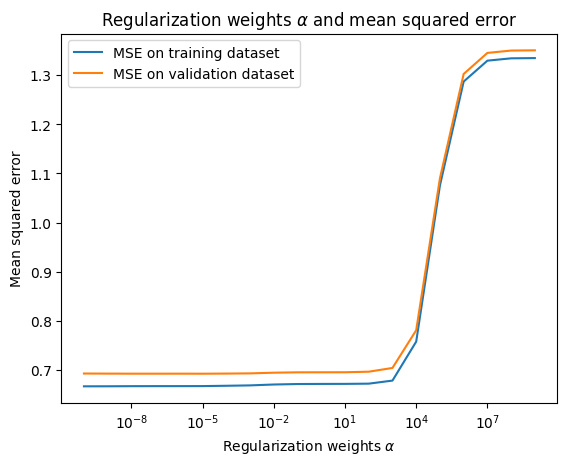

The best alpha: 1e-05
MSE on the test data: 0.7023437052602736


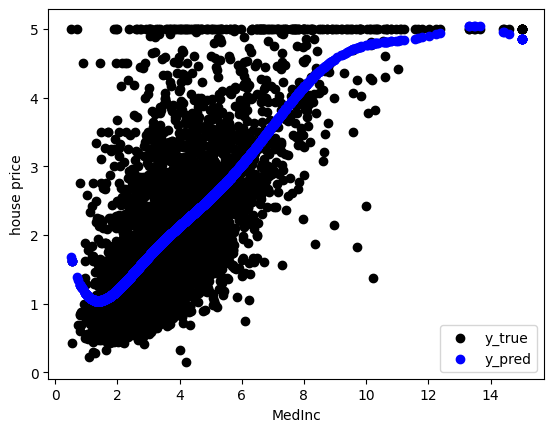

R2 score: 0.4614


In [50]:
#####################
# Load and split data
#####################

# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# Convert the data to `np.array`
X_raw = np.array(X_pd[['MedInc']])
y = np.array(y_pd)

# Split the data
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

###################################
# Initialise Model and preprocessors
###################################

degree = 10 # Choose your degree. Regularisation will eliminate any values that hurt our model, but do beware about going to big, or python may not be able to cope with the number of features.
alpha_indices = np.arange(20) # Get a list of 1-20
alphas = 10.0 ** (alpha_indices -10) # Define a list of alphas by taking indices from 10 to -10
# Get the MSE arrays
mse_train_array = np.full([len(alphas)], np.nan)
mse_valid_array = np.full([len(alphas)], np.nan)

poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

#######################
# Training & validation
#######################

# preprocessing
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)

# Loop to test alpha values
for alpha_index, alpha in zip(alpha_indices, alphas):
  # train
  model = Ridge(alpha=alpha) # fits our ridge model with a new regularisation weight each iteration
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validation
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSEs for this iteration
  mse_train_array[alpha_index] = mse_train
  mse_valid_array[alpha_index] = mse_valid
  print(f'alpha: {alpha}, Validation mean squared error: {mse_valid}.')

# Plot our graph of MSE for training and validation
plt.plot(alphas, mse_train_array, label='MSE on training dataset')
plt.plot(alphas, mse_valid_array, label='MSE on validation dataset')
plt.xlabel(r'Regularization weights $\alpha$')
plt.ylabel('Mean squared error')
plt.title(r'Regularization weights $\alpha$ and mean squared error')
plt.xscale('log')
plt.legend()
plt.show()

# Select our best performing alpha (lowest MSE)
best_alpha_index = np.argmin(mse_valid_array)
best_alpha = alphas[best_alpha_index]
print('The best alpha:', best_alpha)

######
# Test
######

#refit our model with the best alpha
model = Ridge(alpha=best_alpha) # fits our ridge model with a new regularisation weight each iteration
model.fit(X_train, y_train)

# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)

# Predict test data
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test)

# Plot outputs
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))

Looking at this result, we can see that the pipeline chose a different value for $\alpha$, providing a slightly better $R^2$ score and lower MSE than we obtained above (in this case the improvement is marginal, but this may not always be the case!).

##4.2 Example: Lasso regression (linear regression with $\ell^1$ regularization)
Linear regression with the $\ell^1$ regularization term is called Lasso regression, compared to the ridge method we used above which utilises $\ell^2$ regularisation. This also works by changing the cost function.

The cost function of the lasso regression is given as follows:
$$
J_{\alpha} (\boldsymbol{\theta}) = L (\boldsymbol{\theta}) + R_{\alpha} (\boldsymbol{\theta}),
$$
where
$$
L (\boldsymbol{\theta})
=
\frac{1}{m} \sum_{i=0}^{m-1} (y^{(i)} - {\boldsymbol{x}^{(i)}}^{\top} \boldsymbol{\theta})^{2},
$$
and
$$
R_{\alpha} (\boldsymbol{\theta})
=
\frac{\alpha}{m} \sum_{j=1}^{n-1} (\theta_{j}).
$$

Here,
- $L$ is the loss function that gives the mean squared error,
- $R_{\alpha}$ is the regularization function that gives a $\ell^1$ regularization term,
- $\alpha > 0$ is the regularization weight.

  - If $\alpha$ is large, the regularization is strong, and overfitting is strongly avoided, but may cause underfitting.
  - If $\alpha$ is small, the regularization is weak. In this case the model is close to the original model, so it will not prevent overfitting.

We can implement the lasso regression model by a `sklearn.linear_model.Lasso` instance.
The regularization weight is specified by the parameter `alpha`, which corresponds to $\alpha$, in the initializer of the `Lasso` class.

Below I have implemented Lasso Regression for a univariate case. The implementation is almost identical, so I have skipped straight to the automatic $\alpha$ selection. Here it seems to be performing similarly to our Ridge regression, but this may not always be the case.

Note: Our sweep through $\alpha$ values may cause some convergence warning to appear for the Lasso, we don't need to worry about this.

alpha: 1e-10, Validation mean squared error: 0.6954768516815422.
alpha: 1e-09, Validation mean squared error: 0.6954768525764697.
alpha: 1e-08, Validation mean squared error: 0.6954768615241285.
alpha: 1e-07, Validation mean squared error: 0.6954769508403229.
alpha: 1e-06, Validation mean squared error: 0.6954778280178944.
alpha: 1e-05, Validation mean squared error: 0.6954955403432219.
alpha: 0.0001, Validation mean squared error: 0.6956020184348554.
alpha: 0.001, Validation mean squared error: 0.6965271697123125.
alpha: 0.01, Validation mean squared error: 0.7016066694380684.
alpha: 0.1, Validation mean squared error: 0.7240165013039486.
alpha: 1.0, Validation mean squared error: 1.3502698202269434.
alpha: 10.0, Validation mean squared error: 1.3502698202269434.
alpha: 100.0, Validation mean squared error: 1.3502698202269434.
alpha: 1000.0, Validation mean squared error: 1.3502698202269434.
alpha: 10000.0, Validation mean squared error: 1.3502698202269434.
alpha: 100000.0, Validation

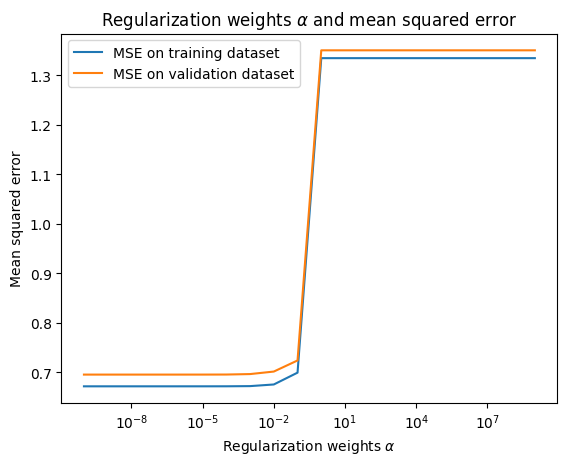

The best alpha: 1e-10
MSE on the test data: 0.7077746933008514


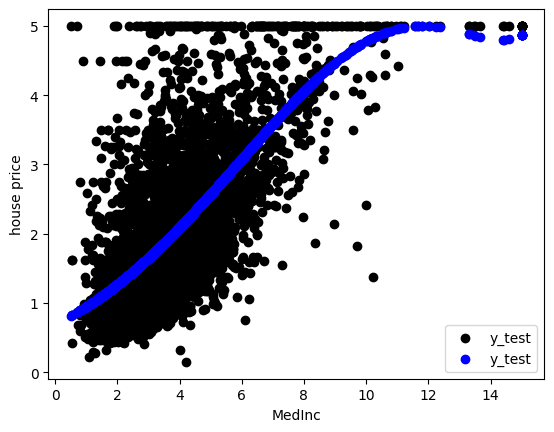

R2 score: 0.4572


In [51]:
#####################
# Load and split data
#####################

# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# Convert the data to `np.array`
X_raw = np.array(X_pd[['MedInc']])
y = np.array(y_pd)

# Split the data
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

###################################
# Initialise Model and preprocessors
###################################

degree = 10 # Choose your degree. Regularisation will eliminate any values that hurt our model, but do beware about going to big, or python may not be able to cope with the number of features.
alpha_indices = np.arange(20) # Get a list of 1-20
alphas = 10.0 ** (alpha_indices -10) # Define a list of alphas by taking indices from 10 to -10
# Get the MSE arrays
mse_train_array = np.full([len(alphas)], np.nan)
mse_valid_array = np.full([len(alphas)], np.nan)

poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

#######################
# Training & validation
#######################

# preprocessing
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)

# Loop to test alpha values
for alpha_index, alpha in zip(alpha_indices, alphas):
  # train
  model = Lasso(alpha=alpha, max_iter=10000) # fits our ridge model with a new regularisation weight each iteration
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validation
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSEs for this iteration
  mse_train_array[alpha_index] = mse_train
  mse_valid_array[alpha_index] = mse_valid
  print(f'alpha: {alpha}, Validation mean squared error: {mse_valid}.')

# Plot our graph of MSE for training and validation
plt.plot(alphas, mse_train_array, label='MSE on training dataset')
plt.plot(alphas, mse_valid_array, label='MSE on validation dataset')
plt.xlabel(r'Regularization weights $\alpha$')
plt.ylabel('Mean squared error')
plt.title(r'Regularization weights $\alpha$ and mean squared error')
plt.xscale('log')
plt.legend()
plt.show()

# Select our best performing alpha (lowest MSE)
best_alpha_index = np.argmin(mse_valid_array)
best_alpha = alphas[best_alpha_index]
print('The best alpha:', best_alpha)

######
# Test
######

#refit our model with the best alpha
model = Lasso(alpha=best_alpha, max_iter=1000, tol=1e-1) # fits our lasso model with a new regularisation weight each iteration
model.fit(X_train, y_train)

# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)

# Predict test data
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test)

# Plot outputs
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_test') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='blue', label='y_test') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))

## 4.3 Exercise 3


Try experimenting with the regularised regression models (Lasso and Ridge) to fit the best multivariable model you can on the California housing dataset.

1.   To begin with, try sample size of `1000`, degree `5` and using all of the features, as this small sample should speed up testing.
2.   Extra: Try manually removing some of the original features (so the features we have before fitting our polynomial features object) one at a time. How does this change the speed and the model accuracy?
3.   Extra: Try changing the degree and sample size. How does the solution speed and best regularisation parameter change as the sample both increases and decreases?
4.   Extra: Check the `model.coef_` values for your best model for Lasso and Ridge regression. What do you notice?


Note:
*   We want to use the automated $\alpha$ selection from above, don't pick degree values manually!
*   Above we were looking at small regularisation rates - we might want stronger regularisation in this case, so you may want to explore a different range of $\alpha$ indices.
*   Be careful if you are using the full dataset with many features - google colab may take a long time fitting models with large numbers of polynomial features, if your code is taking too long to run consider lowering the `degree`, lowering the size of the sample or removing the less impactful features (check the `model.coef_` values to identify which of the coefficients are contributing more to the prediction. Because our features are standardised, we can directly compare the magnitude of our coefficients this way).
-  Extra: Consider using [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) and/or [Grid Search](https://scikit-learn.org/0.17/modules/grid_search.html#grid-search) (see appendices) during your model selection.

alpha: 1e-10, Validation mean squared error: 0.30430228459720504.
alpha: 1e-09, Validation mean squared error: 0.30430261713924467.
alpha: 1e-08, Validation mean squared error: 0.3043014147287755.
alpha: 1e-07, Validation mean squared error: 0.30416551855118695.
alpha: 1e-06, Validation mean squared error: 0.30385809898877914.
alpha: 1e-05, Validation mean squared error: 0.30642268932874006.
alpha: 0.0001, Validation mean squared error: 0.3127636919080464.
alpha: 0.001, Validation mean squared error: 0.31359597211526524.
alpha: 0.01, Validation mean squared error: 0.3140882669323489.
alpha: 0.1, Validation mean squared error: 0.31702293147660326.
alpha: 1.0, Validation mean squared error: 0.32030423105173295.
alpha: 10.0, Validation mean squared error: 0.32920924041056493.
alpha: 100.0, Validation mean squared error: 0.3477407373920464.
alpha: 1000.0, Validation mean squared error: 0.3890314322280946.
alpha: 10000.0, Validation mean squared error: 0.46132852689262843.
alpha: 100000.0, 

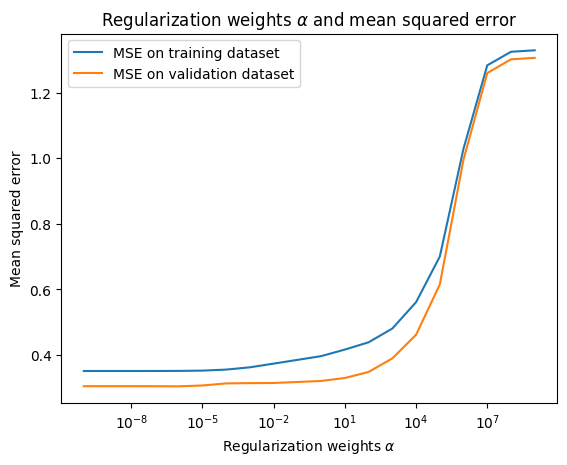

4
[0.30430228 0.30430262 0.30430141 0.30416552 0.3038581  0.30642269
 0.31276369 0.31359597 0.31408827 0.31702293 0.32030423 0.32920924
 0.34774074 0.38903143 0.46132853 0.61452269 0.99579094 1.25962692
 1.30158075 1.30602271]
The best alpha: 1e-06
MSE on the test data: 0.39611011001925367


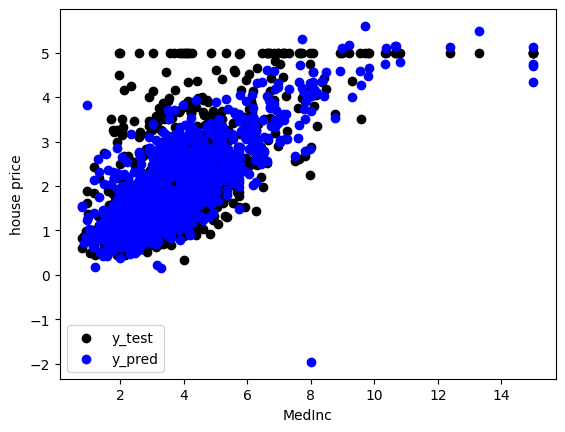

R2 score: 0.7159
[0.0, -130.44908519151187, 179.58876157807256, 239.44185931775692, -66.01463125995114, -26.861225354081338, 522.9861449619766, 184.70855119072462, -223.30712463145954, 16.189703251176443, -7.0337658293691065, 3.980700555099948, -3.4488192539154796, -2.4023082422553808, 26.131364165777104, 64.89550831538034, -165.21094418021684, -5.510700102087089, 14.03944648672027, -8.945693175667145, -3.0888630121769856, -39.63848764648929, 122.30611391208988, 481.87058772410757, -126.30099322577625, 193.78979986414834, 2.0870476108558758, -120.92546590180955, -265.67934758390544, 202.44743671145076, -67.0938765879153, 5.973973636522163, 8.518493505333062, 370.23973725414663, 230.81382808428285, 0.6645246834256854, -71.09979088721529, -52.15900575811495, -104.76484195045911, 182.80786321955216, -444.51128947336485, 450.75846159993665, 316.9366453971511, 893.4322598990134, -221.59884366115332, -0.5192074740653456, -0.4655776683619882, -0.21036806578743117, -0.39471899907234936, -0.415

In [52]:
##############################################################
# Your code here
##############################################################

# Ridge
#####################
# Load and split data
#####################
# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# choose features
col = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']# prepare NumPy ndarrays

# Convert the data to `np.array`
X_raw = np.array(X_pd[col])
y = np.array(y_pd)

# Split the data
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

# For speed I've decided to take a manual subsample of the data
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=500, train_size=6000, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=500, train_size=5500, shuffle=True, random_state=0)


# For speed I've decided to take a manual subsample of the data
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=1000, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=1000, shuffle=True, random_state=0)

###################################
# Initialise Model and preprocessors
###################################

degree = 3 # Choose your degree. Regularisation will eliminate any values that hurt our model, but do beware about going too big, or python may not be able to cope with the number of features.
alpha_indices = np.arange(20) # Get a list of 1-20
alphas = 10.0 ** ( alpha_indices-10) # Define a list of alphas by taking indices from 10 to -10
# Get the MSE arrays
mse_train_array = np.full([len(alphas)], np.nan)
mse_valid_array = np.full([len(alphas)], np.nan)

poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

#######################
# Training & validation
#######################

# preprocessing
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)

# Loop to test alpha values
for alpha_index, alpha in zip(alpha_indices, alphas):
  # train
  model = Ridge(alpha=alpha) # fits our ridge model with a new regularisation weight each iteration
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validation
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSEs for this iteration
  mse_train_array[alpha_index] = mse_train
  mse_valid_array[alpha_index] = mse_valid
  print(f'alpha: {alpha}, Validation mean squared error: {mse_valid}.')

# Plot our graph of MSE for training and validation
plt.plot(alphas, mse_train_array, label='MSE on training dataset')
plt.plot(alphas, mse_valid_array, label='MSE on validation dataset')
plt.xlabel(r'Regularization weights $\alpha$')
plt.ylabel('Mean squared error')
plt.title(r'Regularization weights $\alpha$ and mean squared error')
plt.xscale('log')
plt.legend()
plt.show()

# Select our best performing alpha (lowest MSE)
best_alpha_index = np.nanargmin(mse_valid_array)
print(best_alpha_index)
print(mse_valid_array)
best_alpha = alphas[best_alpha_index]
print('The best alpha:', best_alpha)

######
# Test
######
model = Ridge(alpha=best_alpha) # fits our ridge model with a new regularisation weight each iteration
model.fit(X_train, y_train)
# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)
# Predict test data
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test)

# Plot outputs
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_test') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))

# View coefs
coefList=model.coef_.tolist()
print(coefList)

alpha: 1e-05, Validation mean squared error: 0.3366890784816732.
alpha: 0.0001, Validation mean squared error: 0.3351373363333705.
alpha: 0.001, Validation mean squared error: 0.3368297860248979.
alpha: 0.01, Validation mean squared error: 0.41308676103085457.
alpha: 0.1, Validation mean squared error: 0.5658965096520112.
alpha: 1.0, Validation mean squared error: 1.3065191947909982.
alpha: 10.0, Validation mean squared error: 1.3065191947909982.
alpha: 100.0, Validation mean squared error: 1.3065191947909982.
alpha: 1000.0, Validation mean squared error: 1.3065191947909982.
alpha: 10000.0, Validation mean squared error: 1.3065191947909982.


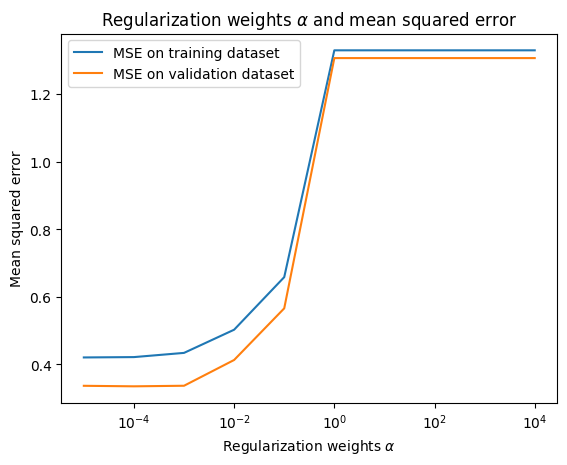

The best alpha: 0.0001
MSE on the test data: 0.4692423741216037


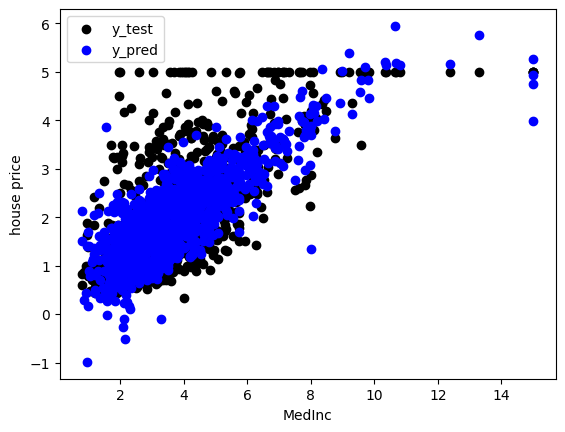

R2 score: 0.6635
[0.0, 0.25636008767391627, -0.2363983137611088, 0.13263407931926618, 0.20000481694276417, -0.12501887133929848, -0.04364825718727973, -0.3446373507423818, -0.5909720826085424, 0.29629260382712846, 0.39175856251822494, 0.1306373171755409, 0.07477318598633054, 0.052988440377996056, 0.041434900891420344, -0.6478532306912095, -0.12560459560913165, -0.09404553834005577, -0.31335780044047085, 0.15906378672654622, -0.18247275989111159, -0.4745578778181533, -0.0, -0.12128003097798123, 0.07656267835470562, -0.10818559200692986, -0.05529236504897, 0.444088902421809, 0.0, 0.09574849155646899, -0.0460432926754988, 0.15907081897955885, 0.2628706895990184, -0.15541506131288046, -0.056910184226454684, 0.23944679123422646, 0.1802150433241368, -0.0, 0.15405085950459374, 0.30745706313075166, 0.005884322878442526, 0.678807932166173, 0.004678234441788646, 0.41770891994301873, 0.3708812923672028, -1.0156665297010736, -0.6204870553209869, -0.1056126970721446, -0.135211413976879, -0.00059937

In [53]:
##############################################################
# Your code here
##############################################################
#Lasso
#####################
# Load and split data
#####################
# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# choose features
col = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']# prepare NumPy ndarrays

# Convert the data to `np.array`
X_raw = np.array(X_pd[col])
y = np.array(y_pd)

# Split the data - I found that 60:20:20 didn't give me enough training data
#X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
#X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

# Here I've manually set the size of the testing data, but it is approximately 90:5:5
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=1000, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=1000, shuffle=True, random_state=0)

###################################
# Initialise Model and preprocessors
###################################

degree = 3 # Choose your degree. Regularisation will try to eliminate any values that hurt our model, but do beware about going to big, or python may not be able to cope with the number of features.
alpha_indices = np.arange(10) # Get a list of 1-30
alphas = 10.0 ** (alpha_indices-5) # Define a list of alphas by taking indices from -15 to +15
# Get the MSE arrays
mse_train_array = np.full([len(alphas)], np.nan)
mse_valid_array = np.full([len(alphas)], np.nan)

poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

#######################
# Training & validation
#######################

# preprocessing
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)

# Loop to test alpha values
for alpha_index, alpha in zip(alpha_indices, alphas):
  # train
  model = Lasso(alpha=alpha) # fits our Lasso model with a new regularisation weight each iteration
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validation
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSEs for this iteration
  mse_train_array[alpha_index] = mse_train
  mse_valid_array[alpha_index] = mse_valid
  print(f'alpha: {alpha}, Validation mean squared error: {mse_valid}.')

# Plot our graph of MSE for training and validation
plt.plot(alphas, mse_train_array, label='MSE on training dataset')
plt.plot(alphas, mse_valid_array, label='MSE on validation dataset')
plt.xlabel(r'Regularization weights $\alpha$')
plt.ylabel('Mean squared error')
plt.title(r'Regularization weights $\alpha$ and mean squared error')
plt.xscale('log')
plt.legend()
plt.show()

# Select our best performing alpha (lowest MSE)
best_alpha_index = np.argmin(mse_valid_array)
best_alpha = alphas[best_alpha_index]
print('The best alpha:', best_alpha)

######
# Test
######

#refit our model with the best alpha
model = Lasso(alpha=best_alpha) # fits our Lasso model with a new regularisation weight each iteration
model.fit(X_train, y_train)

# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)

# Predict test data
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test)

# Plot outputs
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_test') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))

# View coefs
coefList=model.coef_.tolist()
print(coefList)

##4.4 Exercise 4

You should now have all the fundamental tools you need to systematically choose the best regression model for a given dataset for a traditional Machine Learning problem. (Though by all means do your own research into other models and methods you can apply to supervised learning problems!)

For this exercise, use the dataset on the compressive strength of concrete(`T4-Dataset-2.csv`) which I have uploaded to moodle and see how good a regression model you can implement using all the tools we have discussed over the last two weeks. With a little experimentation I was able to get an $R^2$ score of about 85% - can you beat me?

Notes:
- This Concrete dataset is also available at the following link donated by Prof. I-Cheng Yeh: https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength
- With only 1000 datapoints, you can probably work with the whole dataset, but if you want to explore high polynomial features (say above 10) in a reasonable time you might have to work with a smaller sample and/or remove features to test things in a reasonable time.
-  Extra: Consider using [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) and/or [Grid Search](https://scikit-learn.org/0.17/modules/grid_search.html#grid-search) (see appendices) during your model selection.
- Extra: You could see how non parametric methods perform (e.g. Decision Trees & K-nearest neighbours)

alpha: 1e-10, Validation mean squared error: 768190.2566361486.
alpha: 1e-09, Validation mean squared error: 60937.85561493721.
alpha: 1e-08, Validation mean squared error: 12753.966579070613.
alpha: 1e-07, Validation mean squared error: 8402.001853103322.
alpha: 1e-06, Validation mean squared error: 3117.421673741568.
alpha: 1e-05, Validation mean squared error: 987.6224851319032.
alpha: 0.0001, Validation mean squared error: 418.9095626415103.
alpha: 0.001, Validation mean squared error: 246.84837907176862.
alpha: 0.01, Validation mean squared error: 121.08910913957654.
alpha: 0.1, Validation mean squared error: 49.793724625438415.
alpha: 1.0, Validation mean squared error: 31.89511083892347.
alpha: 10.0, Validation mean squared error: 34.47130750770331.
alpha: 100.0, Validation mean squared error: 41.43908249603067.
alpha: 1000.0, Validation mean squared error: 53.84912328169065.
alpha: 10000.0, Validation mean squared error: 80.4018012761116.
alpha: 100000.0, Validation mean square

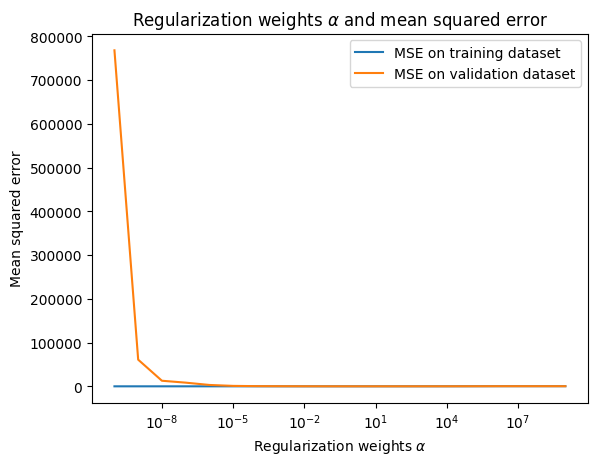

The best alpha: 1.0
MSE on the test data: 40.34792902320763


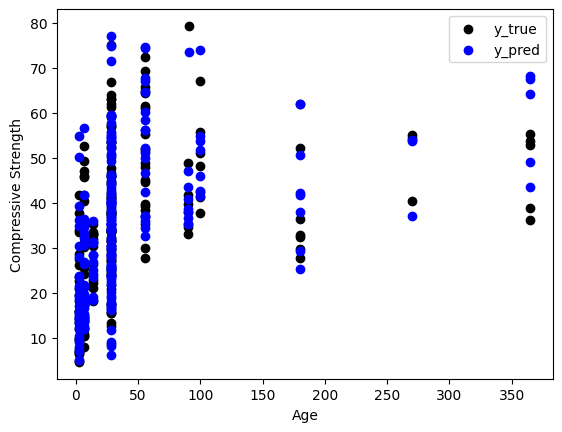

R2 score: 0.8468
[0.0, 2.8010812033474224, -1.2859839654336713, -1.2906673937094235, 4.968731088086078, -1.4221130259136447, -1.4647582174846216, 0.19242235624842333, 1.7865711429645537, 1.5905566435897323, -0.6078578332959789, 0.5814654051556001, 2.5079584999723203, 0.08027481771468102, 2.1921705291404696, 1.9499059740747393, 1.3297346208394254, -0.3266970316954867, -2.136510635960784, -0.14062626258236421, -0.5010177281745456, -1.48114945740269, -0.6499802697132686, 0.44077625379236424, -1.752189195257155, -0.43945573038347185, -0.3193874986848424, -0.9768591862683746, -0.5213726544139207, 0.5329335620166906, 3.0629373118938448, -1.0771495274069944, 1.9821796984824571, 3.7929129017010434, 1.2384092489363252, -0.33239257940687733, -1.0019591124200946, -0.527277534208211, 0.7253121987001568, -0.6310122270770621, -0.1939320786336245, 1.146170756514158, -0.19711725223784407, 1.9926827601622417, -1.1820038415591576, 1.1416468737104861, -0.04783092112775888, 0.8933376021921489, 0.336053277

In [54]:
##############################################################
# Your code here
##############################################################

#####################
# Load and split data
#####################
# uploaded = files.upload()    # Will prompt you to select file
# Your file is now in the Colab filesystem on the left
conc = pd.read_csv('T4-Dataset-2.csv') # Save it to a pandas dataframe

# choose features
col = ['Cement','BlastFurnaceSlag','FlyAsh','Water','Superplasticizer','CoarseAggregate','FineAggregate','Age'] # defined a new variable for the column names to make it easier to experiment with adding or removing columns
X_raw = np.array(conc[col])
y = np.array(conc['CompressiveStrength'])

# Split the data
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=0.25, shuffle=True, random_state=0)

####################################
# Initialise Model and preprocessors
####################################

degree = 5 # Choose your degree. Regularisation will eliminate any values that hurt our model, but do beware about going to big, or python may not be able to cope with the number of features.
alpha_indices = np.arange(20) # Get a list of 1-20
alphas = 10.0 ** (alpha_indices-10) # Define a list of alphas by taking indices from 10 to -10
# Get the MSE arrays
mse_train_array = np.full([len(alphas)], np.nan)
mse_valid_array = np.full([len(alphas)], np.nan)

poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

#######################
# Training & validation
#######################

# preprocessing
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)

# Loop to test alpha values
for alpha_index, alpha in zip(alpha_indices, alphas):
  # train
  model = Ridge(alpha=alpha) # fits our ridge model with a new regularisation weight each iteration
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validation
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSEs for this iteration
  mse_train_array[alpha_index] = mse_train
  mse_valid_array[alpha_index] = mse_valid
  print(f'alpha: {alpha}, Validation mean squared error: {mse_valid}.')

# Plot our graph of MSE for training and validation
plt.plot(alphas, mse_train_array, label='MSE on training dataset')
plt.plot(alphas, mse_valid_array, label='MSE on validation dataset')
plt.xlabel(r'Regularization weights $\alpha$')
plt.ylabel('Mean squared error')
plt.title(r'Regularization weights $\alpha$ and mean squared error')
plt.xscale('log')
plt.legend()
plt.show()

# Select our best performing alpha (lowest MSE)
best_alpha_index = np.argmin(mse_valid_array)
best_alpha = alphas[best_alpha_index]
print('The best alpha:', best_alpha)

######
# Test
######

#refit our model with the best alpha
model = Ridge(alpha=best_alpha) # fits our ridge model with the best regularisation weight
model.fit(X_train, y_train)

# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)

# Predict test data
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test)

# Plot outputs
plt.scatter(X_test_raw[:,7], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,7], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('Age')
plt.ylabel('Compressive Strength')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))


# View coefs
coefList=model.coef_.tolist()
print(coefList)

##4.5 Exercise 5

If you have completed everything else, you could go back to our example of school test results from **Exercise 1**  (`T4-Dataset-1.csv`) with the categorical features. Take the answer you got for this exercise, but now try applying all of the other things we've seen in this week's tutorial to see if we can improve our accuracy! I was able to get nearly 98%, can we do any better?

Some things to try:

*   Perform more robust data splitting with train/validation/test sets.
*   Perform pre-processing on the numerical features
*  See if polynomial features have an impact.
*  You can use Ridge/Lasso regularisation (or even try a non parametric approach like a [decision tree](https://scikit-learn.org/stable/modules/tree.html#tree)).
*  Extra: Consider using cross validation and/or grid searches (see appendices) during your model selection.

alpha: 1e-10, Validation mean squared error: 28.524480451708417.
alpha: 1e-09, Validation mean squared error: 28.5244101331033.
alpha: 1e-08, Validation mean squared error: 28.523707702702147.
alpha: 1e-07, Validation mean squared error: 28.51675406790717.
alpha: 1e-06, Validation mean squared error: 28.45359922591256.
alpha: 1e-05, Validation mean squared error: 28.13019009911406.
alpha: 0.0001, Validation mean squared error: 27.66682418490833.
alpha: 0.001, Validation mean squared error: 27.498857527914595.
alpha: 0.01, Validation mean squared error: 26.270056705378984.
alpha: 0.1, Validation mean squared error: 26.412420392103012.
alpha: 1.0, Validation mean squared error: 35.85458231762391.
alpha: 10.0, Validation mean squared error: 42.83916096459583.
alpha: 100.0, Validation mean squared error: 61.54295646910697.
alpha: 1000.0, Validation mean squared error: 114.41636478704126.
alpha: 10000.0, Validation mean squared error: 319.15497821391983.
alpha: 100000.0, Validation mean squ

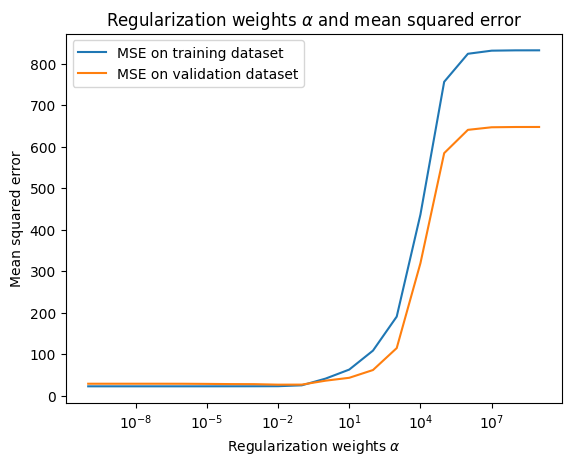

The best alpha: 0.01
MSE on the test data: 17.333566802496662


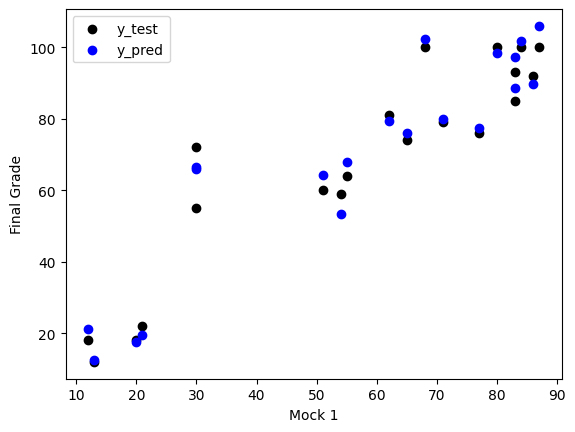

R2 score: 0.9791


In [55]:
##############################################################
# Your code here
##############################################################

#####################
# Load and split data
#####################
# Load the house price dataset
testData = pd.read_csv('T4-Dataset-1.csv') # Save it to a pandas dataframe
testData_enc = testData.copy() #note we are using the dataset with no missing values

tar='finalGrade'

# create an object of the LabelEncoder class
lblEncoder_X = LabelEncoder()
testData_enc['studyTime'] = lblEncoder_X.fit_transform(testData_enc['studyTime'])
testData_enc['travelTime'] = lblEncoder_X.fit_transform(testData_enc['travelTime'])
testData_enc['absence'] = lblEncoder_X.fit_transform(testData_enc['absence'])
testData_enc['school'] = lblEncoder_X.fit_transform(testData_enc['school'])

col_fin=['mock1','mock2','studyTime','travelTime','absence','school']

X = np.array(testData_enc[col_fin])
y = np.array(testData_enc[tar])

# Split the data
X_non_test_raw, X_test_raw, y_non_test, y_test = train_test_split(X, y, test_size=1/20, shuffle=True, random_state=0)
X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X_non_test_raw, y_non_test, test_size=1/19, shuffle=True, random_state=0)


###################################
# Initialise Model and preprocessors
###################################

degree = 3 # Choose your degree. Regularisation will eliminate any values that hurt our model, but do beware about going too big, or python may not be able to cope with the number of features.
alpha_indices = np.arange(20) # Get a list of 1-20
alphas = 10.0 ** ( alpha_indices-10) # Define a list of alphas by taking indices from 10 to -10
# Get the MSE arrays
mse_train_array = np.full([len(alphas)], np.nan)
mse_valid_array = np.full([len(alphas)], np.nan)

poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

#######################
# Training & validation
#######################

# preprocessing
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)
X_valid_poly = poly.transform(X_valid_raw)
X_valid = scaler.transform(X_valid_poly)

# Loop to test alpha values
for alpha_index, alpha in zip(alpha_indices, alphas):
  # train
  model = Ridge(alpha=alpha) # fits our ridge model with a new regularisation weight each iteration
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  mse_train = mean_squared_error(y_train, y_pred_train)

  # Validation
  y_pred_valid = model.predict(X_valid)
  mse_valid = mean_squared_error(y_valid, y_pred_valid)

  # Store MSEs for this iteration
  mse_train_array[alpha_index] = mse_train
  mse_valid_array[alpha_index] = mse_valid
  print(f'alpha: {alpha}, Validation mean squared error: {mse_valid}.')

# Plot our graph of MSE for training and validation
plt.plot(alphas, mse_train_array, label='MSE on training dataset')
plt.plot(alphas, mse_valid_array, label='MSE on validation dataset')
plt.xlabel(r'Regularization weights $\alpha$')
plt.ylabel('Mean squared error')
plt.title(r'Regularization weights $\alpha$ and mean squared error')
plt.xscale('log')
plt.legend()
plt.show()

# Select our best performing alpha (lowest MSE)
best_alpha_index = np.nanargmin(mse_valid_array)
best_alpha = alphas[best_alpha_index]
print('The best alpha:', best_alpha)

######
# Test
######
model = Ridge(alpha=best_alpha) # fits our ridge model with a new regularisation weight each iteration
model.fit(X_train, y_train)
# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)
# Predict test data
y_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)

print('MSE on the test data:', mse_test)


X_test_disp = X_test_raw[:,1] # We will need to make a special vector for the feature we want on the x axis, as now X is a matrix matplotlib can't use it for a scatter plot

# Plot outputs
plt.scatter(X_test_disp, y_test,  color='black', label='y_test') # Observed y values
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred') # predicted y values
plt.xlabel('Mock 1')
plt.ylabel('Final Grade')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))


# Appendix 1: Cross Validation

Cross validation is an alternative way to evaluate your models during the model selection process.

Rather than splitting your data into train/validation/test sets, initially you only split it into train/test sets.

Then the training date is split into `k` folds (essentially subsamples of the training data). You then fit your model `k` times, using `k-1` of the folds for training and `1` fold for validation (changing the validation fold each time). You then take the average of the performance metrics (MSE/$R^2$), which gives you a more thorough idea of if your model is robust as by the end of this process it has been tested on all of the training data. If it passes the k-fold cross validation and you are happy with the average performance, you can then fit the model again on the ***entire*** training dataset and evaluate this final model using the test data.

Issues with this is of course it is more computationally expensive as you are fitting `k-1` more models (which isn't a big deal with small datasets, but makes this approach impractical for larger datasets). Also it complicates the process for testing for hyperparameters as we would then have to include the cross validation in that wider loop (often if you want to perform a study with cross validation you would use some sort of pre-made grid search method - see the next appendix).

You are not required to implement Cross validation to do well in your coursework, but you may implement it if you wish as it is a widely used and thorough way to evaluate your model prior to testing.

See the sklearn documentation [here](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) for more details.

Validation points: [    7     8     9 ... 16504 16510 16511]
Training points: [    0     1     2 ... 16507 16508 16509]
0.5341085067560144
0.5995618960486654
 
Validation points: [   14    23    29 ... 16493 16500 16506]
Training points: [    0     1     2 ... 16509 16510 16511]
0.5838633108580117
0.580271734293887
 
Validation points: [    5     6    15 ... 16501 16505 16508]
Training points: [    0     1     2 ... 16509 16510 16511]
0.5302418608518669
0.602564405116265
 
Validation points: [    1     2     3 ... 16499 16503 16507]
Training points: [    0     5     6 ... 16509 16510 16511]
0.5103269581176507
0.6181920287471453
 
Validation points: [    0    13    21 ... 16489 16498 16509]
Training points: [    1     2     3 ... 16508 16510 16511]
0.4903839254698823
0.6209918837743089
 
Average MSE on validation data: 0.5297849124106853
Average R2 score on validation data: 0.6043163895960543


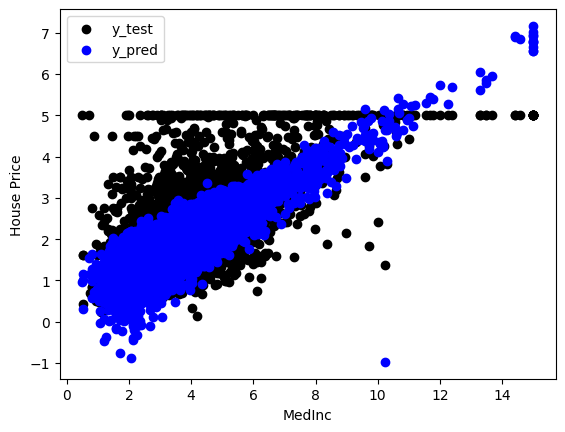

Mean squared error loss on test data: 0.5290
R2 score on test data: 0.5943


In [56]:
from sklearn.model_selection import KFold

# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# Extract the Median Income feature
X_raw = np.array(X_pd)
y_raw = np.array(y_pd)

# Split the data into training/test data
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.20, shuffle=True, random_state=0)

# Create linear regression object
model = LinearRegression()

# Define K-fold Cross Validation object

# n_splits - how many 'folds' you want to use to evalaute your model.
# 5 folds is pretty standard, I wouldn't advise going much smaller than that, and unless you have a good rationale I would generally not go above 10.
# While generally you want the k-fold splitting to give you folds of a similar size to your test data, this doesn't have to be too closely monitored.
# You want to have a balance between what is computationally sensible with having enough folds to ensure you are happy with the testing thoroughness.

# shuffle - shuffles your data while performing the k-fold splitting. Generally you want to do this as it just helps make the process even more robust.
# random state - give the random seed for the shuffling. This means you can generate the same pseudorandom sample each time to aid comparison.
kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Create empty lists to fill with out MSE and R2 values
mse_list = []
r2_list = []

for train_index, valid_index in kf.split(X_train):
    print('Validation points:', valid_index)
    print('Training points:',train_index)

    # split our full training data into the CV train and validation for this fold
    X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]
    y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]

    # Train the model
    model.fit(X_train_cv, y_train_cv)

    # Make predictions on the validation set
    y_pred_valid = model.predict(X_valid_cv)

    # Calculate metrics
    mse_valid = mean_squared_error(y_valid_cv, y_pred_valid)
    r2_valid = r2_score(y_valid_cv, y_pred_valid)

    print(mse_valid)
    print(r2_valid)
    print(' ')

    # Store results for this fold
    mse_list.append(mse_valid)
    r2_list.append(r2_valid)

# Calculate average MSE and R2 across folds
avg_mse = np.mean(mse_list)
avg_r2 = np.mean(r2_list)

print('Average MSE on validation data:', avg_mse)
print('Average R2 score on validation data:', avg_r2)

# Now, let's train the model on the full training set and evaluate on the test set
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

# Plot outputs
plt.scatter(X_test[:, 0], y_test, color='black', label='y_test')  # Observed y values
plt.scatter(X_test[:, 0], y_pred_test, color='blue', label='y_pred')  # Predicted y values
plt.xlabel('MedInc')
plt.ylabel('House Price')
plt.legend()
plt.show()

# The mean squared error loss on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
print('Mean squared error loss on test data: {:.4f}'.format(mse_test))

# The R2 score on the test set: 1 is perfect prediction
r2_test = r2_score(y_test, y_pred_test)
print('R2 score on test data: {:.4f}'.format(r2_test))


Below is an expanded example where we are using cross validation to help us chose an optimal regularisation strength. While certainly workable, it significantly increases the computational load and does complicate our code further - so depending on how much we want to test a grid search may be a better choice.

alpha: 1e-05, Validation average mean squared error: 0.649736140747632.
alpha: 0.0001, Validation average mean squared error: 0.6497360706518329.
alpha: 0.001, Validation average mean squared error: 0.6497353789507276.
alpha: 0.01, Validation average mean squared error: 0.6497292409788938.
alpha: 0.1, Validation average mean squared error: 0.6496951675791617.
alpha: 1.0, Validation average mean squared error: 0.6495393176927637.
alpha: 10.0, Validation average mean squared error: 0.649349463712184.
alpha: 100.0, Validation average mean squared error: 0.6496400717865354.
alpha: 1000.0, Validation average mean squared error: 0.6537289813395161.
alpha: 10000.0, Validation average mean squared error: 0.7486551436411202.


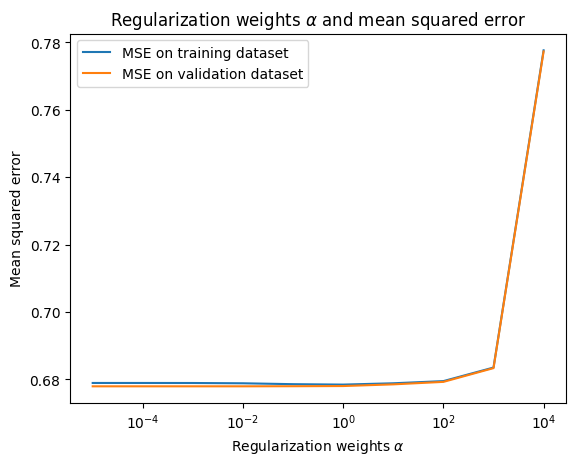

The best alpha: 1e-05
MSE on the test data: 0.7079724337883072


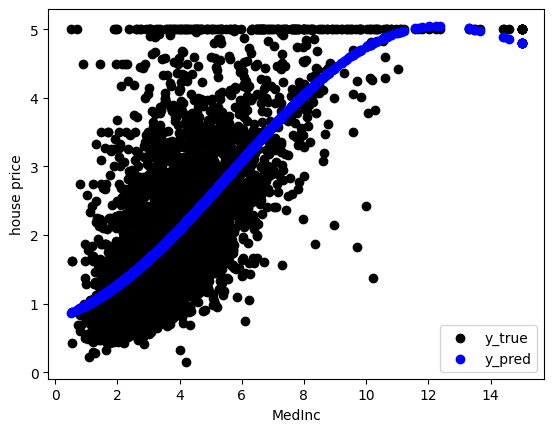

R2 score: 0.4571


In [57]:
#####################
# Load and split data
#####################

# Load the house price dataset
X_pd, y_pd = sklearn.datasets.fetch_california_housing(return_X_y=True, as_frame=True)

# Convert the data to `np.array`
X_raw = np.array(X_pd[['MedInc']])
y = np.array(y_pd)

# Split the data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, shuffle=True, random_state=0)

###################################
# Initialise Model and preprocessors
###################################

degree = 5 # Choose your degree. Regularisation will eliminate any values that hurt our model, but do beware about going to big, or python may not be able to cope with the number of features.
alpha_indices = np.arange(10) # Get a list of 1-10
alphas = 10.0 ** (alpha_indices -5) # Define a list of alphas by taking indices from 5 to -5
# Get the MSE arrays
mse_train_array = np.full([len(alphas)], np.nan)
mse_valid_array = np.full([len(alphas)], np.nan)

poly = PolynomialFeatures(degree=degree)
scaler = StandardScaler()

#######################
# Training & validation
#######################

# preprocessing
poly.fit(X_train_raw)
X_train_poly = poly.transform(X_train_raw)
scaler.fit(X_train_poly)
X_train = scaler.transform(X_train_poly)

# Loop to test alpha values
for alpha_index, alpha in zip(alpha_indices, alphas):
  # train
  model = Ridge(alpha=alpha) # fits our ridge model with a new regularisation weight each iteration
  mse_list_tr = []
  mse_list_val = []

  for train_index, valid_index in kf.split(X_train):
    # split our full training data into the CV train and validation for this fold
    X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]
    y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]

    # Train the model
    model.fit(X_train_cv, y_train_cv)

    # Make predictions
    y_pred_train = model.predict(X_train_cv)
    y_pred_valid = model.predict(X_valid_cv)

    # Calculate metrics
    mse_train = mean_squared_error(y_train_cv, y_pred_train)
    mse_valid = mean_squared_error(y_valid_cv, y_pred_valid)

    # Store results for this fold
    mse_list_tr.append(mse_train)
    mse_list_val.append(mse_valid)

    # Calculate average MSE across folds
    avg_mse_val = np.mean(mse_list_tr)
    avg_mse_train = np.mean(mse_list_val)

  # Store MSEs for this iteration
  mse_train_array[alpha_index] = avg_mse_train
  mse_valid_array[alpha_index] = avg_mse_val
  print(f'alpha: {alpha}, Validation average mean squared error: {mse_valid}.')

# Plot our graph of MSE for training and validation
plt.plot(alphas, mse_train_array, label='MSE on training dataset')
plt.plot(alphas, mse_valid_array, label='MSE on validation dataset')
plt.xlabel(r'Regularization weights $\alpha$')
plt.ylabel('Mean squared error')
plt.title(r'Regularization weights $\alpha$ and mean squared error')
plt.xscale('log')
plt.legend()
plt.show()

# Select our best performing alpha (lowest MSE)
best_alpha_index = np.argmin(mse_valid_array)
best_alpha = alphas[best_alpha_index]
print('The best alpha:', best_alpha)

######
# Test
######

#refit our model with the best alpha
model = Ridge(alpha=best_alpha) # fits our ridge model with a new regularisation weight each iteration
model.fit(X_train, y_train)

# Preprocess test data
X_test_poly = poly.transform(X_test_raw)
X_test = scaler.transform(X_test_poly)

# Predict test data
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test)

# Plot outputs
plt.scatter(X_test_raw[:,0], y_test,  color='black', label='y_true') # Observed y values
plt.scatter(X_test_raw[:,0], y_pred_test, color='blue', label='y_pred') # predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred_test)))

#Appendix 2: Grid Search

Using grid search is an alternative to setting up your own studies (like we have been doing so far). This is a predefined framework in `sklearn` that can be test models using a variety of user defined hyperparameters to find the combination that provides the best results. Of course, this can be a very slow process and many models are being fitted and evaluated - so while grid search does allow you to test a lot of combinations, it is useful if you have the knowledge to provide it with smaller lists of options that you believe are most likely to obtain good results - as python risks timing out and/or running out of memory if you provide too large a list.

You are free to use Grid Searches in your coursework (but this is not required for a top grade), but if you do so some things I want you to bear in mind:
- Grid search does not magically give you the 'best' answer. You as the developer are choosing what hyperparameters to test and what values to use, along with other choices such as preprocessing and data splitting that can have a massive impact on the results.
- It's also impossible to test every permutation of hyperparameter values, so it's always possible a different permutation you never tested will give you a better model.
- You don't have to end your model selection with a single grid search. You can investigate the results and this may give you an idea of different parameters to try testing (either manually now or with further grid searches).
- You don't have to accept the top result of a GridSeach as your final model choice - there are reasons other than the final score function for why you may choose one model over another.

if you use grid search in your coursework I would expect you to clearly show what hyperparameters and hyperparameter values have been chosen to test, with some justifications give for these choices. Further interrogation of the grid search results and potentially even further testing (manual or using more grid searches) before selecting a final model will be looked on favourably.

I'm going to be using `GridSearchCV`, which includes cross validation in it's selection process, but there are [other inbuilt search methods](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) in sklearn you can experiment with.

Best Hyperparameters: {'poly__degree': 1, 'ridge__alpha': 10}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('scaler', StandardScaler()), ('ridge', Ridge(alpha=10))])
MSE on the test data: 0.5364495710558183


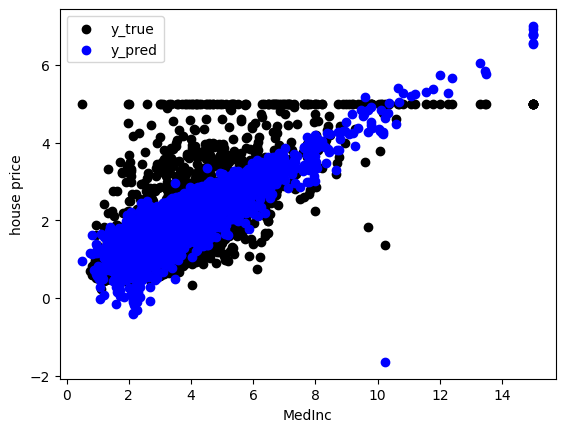

R2 score: 0.6097


In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_california_housing

# Load the house price dataset
X_pd, y_pd = fetch_california_housing(return_X_y=True, as_frame=True)

# Convert the data to `np.array`
X_raw = np.array(X_pd)
y = np.array(y_pd)

# Split the data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.1, shuffle=True, random_state=0)

# Hyperparameter grid for GridSearchCV
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10],  # Values for Ridge alpha
    'poly__degree': [1, 2, 3, 4, 5],  # Values for PolynomialFeatures degree
}

# Initialize Model and preprocessors
ridge = Ridge()
poly = PolynomialFeatures()  # Apply PolynomialFeatures only to the selected feature
scaler = StandardScaler()

# Create a pipeline with preprocessing and Ridge regression
# Pipelines can be used outside of grid searchs to give you a tidier process
# essentially they roll up multiple preprocesing operations with the model so it only requires 'fitting' once
pipeline = Pipeline([
    ('poly', poly),
    ('scaler', scaler),
    ('ridge', ridge)
])

# Initialize GridSearchCV
# Pipeline - provide teh model (or pipeline) that you want to test teh grid search on
# param_grid - the hyperparameter values you wish to test. Must make sure these
# align with the hyperparameters of the pipeline being fitted or there will be an error.
# cv - cross validation folds to use
# scoring - how to evaluate the different models, many options, but for our regression problem I have chosen R2.
# n_jobs - this allows parallel processing to be use multiple processors to run the search quicker.
# Unless you have a good reason, I would leave as '-1' so all available processors are used.
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit the model with GridSearchCV
grid_search.fit(X_train_raw, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Print the best model
print("Best Model:", best_model)

# Train the best model on the full training set
best_model.fit(X_train_raw, y_train)

# Predict test data
y_pred_test = best_model.predict(X_test_raw)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test)

# Plot outputs
plt.scatter(X_test_raw[:, 0], y_test,  color='black', label='y_true')  # Observed y values
plt.scatter(X_test_raw[:, 0], y_pred_test, color='blue', label='y_pred')  # Predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(r2_score(y_test, y_pred_test)))


If you are using grid search properly, you should also be looking into all of the results for the entire set of combinations tested. This is good for giving you a better idea of what is and isn't working well (that may be used for further experimentation). You may also look at these results and decide that the 'best' model isn't actually the one you want to use - for example you may have a simpler model that only marginally comes in second place, but will be much more robust when deployed.

One way of doing this is shown below, where all of the results have been put into a sorted table.

In [59]:
# Get the results as a DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display the relevant columns
relevant_columns = ['params', 'mean_test_score', 'std_test_score']
cv_results[relevant_columns].sort_values(by='mean_test_score', ascending=False)


,params,mean_test_score,std_test_score
3,"{'poly__degree': 1, 'ridge__alpha': 10}",0.601854,0.017938
2,"{'poly__degree': 1, 'ridge__alpha': 1}",0.601832,0.018000
1,"{'poly__degree': 1, 'ridge__alpha': 0.1}",0.601829,0.018006
0,"{'poly__degree': 1, 'ridge__alpha': 0.01}",0.601829,0.018007
6,"{'poly__degree': 2, 'ridge__alpha': 1}",0.560827,0.115117
11,"{'poly__degree': 3, 'ridge__alpha': 10}",0.390058,0.253751
7,"{'poly__degree': 2, 'ridge__alpha': 10}",0.369150,0.405311
5,"{'poly__degree': 2, 'ridge__alpha': 0.1}",0.297629,0.707124
4,"{'poly__degree': 2, 'ridge__alpha': 0.01}",-1.960963,4.890334
10,"{'poly__degree': 3, 'ridge__alpha': 1}",-3.096446,5.797949


Grid searches can potentially be used with almost any model (it is possible, but more complicated with Neural Networks...). So as an additional example, here is a Decision tree model fitted using grid search.

Best Hyperparameters: {'poly__degree': 1, 'tree__max_depth': 10, 'tree__min_samples_split': 5}
Best Model: Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                ('scaler', StandardScaler()),
                ('tree',
                 DecisionTreeRegressor(max_depth=10, min_samples_split=5))])
MSE on the test data: 0.45299678919700204


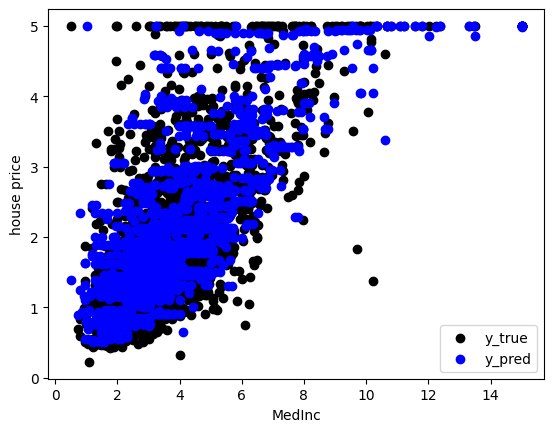

R2 score: 0.6704


In [60]:
from sklearn.tree import DecisionTreeRegressor

# Load the house price dataset
X_pd, y_pd = fetch_california_housing(return_X_y=True, as_frame=True)

# Convert the data to `np.array`
X_raw = np.array(X_pd)
y = np.array(y_pd)

# Split the data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.1, shuffle=True, random_state=0)

# Hyperparameter grid for GridSearchCV
param_grid = {
    'poly__degree': [1, 2],  # Values for PolynomialFeatures degree
    'tree__max_depth': [None, 5, 10],  # Values for DecisionTreeRegressor max depth
    'tree__min_samples_split': [None, 2, 5],  # Values for DecisionTreeRegressor min_samples_split
}

# Initialize Model and preprocessors
tree = DecisionTreeRegressor()
poly = PolynomialFeatures()  # Apply PolynomialFeatures only to the selected feature
scaler = StandardScaler()

# Create a pipeline with preprocessing and Decision Tree regression
pipeline = Pipeline([
    ('poly', poly),
    ('scaler', scaler),
    ('tree', tree)
])

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit the model with GridSearchCV
grid_search.fit(X_train_raw, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Print the best model
print("Best Model:", best_model)

# Train the best model on the full training set
best_model.fit(X_train_raw, y_train)

# Predict test data
y_pred_test = best_model.predict(X_test_raw)
mse_test = mean_squared_error(y_test, y_pred_test)

print('MSE on the test data:', mse_test)

# Plot outputs
plt.scatter(X_test_raw[:, 0], y_test,  color='black', label='y_true')  # Observed y values
plt.scatter(X_test_raw[:, 0], y_pred_test, color='blue', label='y_pred')  # Predicted y values
plt.xlabel('MedInc')
plt.ylabel('house price')
plt.legend()
plt.show()

# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(r2_score(y_test, y_pred_test)))


In [61]:
# Get the results as a DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display the relevant columns
relevant_columns = ['params', 'mean_test_score', 'std_test_score']
cv_results[relevant_columns].sort_values(by='mean_test_score', ascending=False)

,params,mean_test_score,std_test_score
8,"{'poly__degree': 1, 'tree__max_depth': 10, 'tr...",0.685078,0.010662
7,"{'poly__degree': 1, 'tree__max_depth': 10, 'tr...",0.682919,0.011097
17,"{'poly__degree': 2, 'tree__max_depth': 10, 'tr...",0.680576,0.010028
16,"{'poly__degree': 2, 'tree__max_depth': 10, 'tr...",0.678661,0.007190
14,"{'poly__degree': 2, 'tree__max_depth': 5, 'tre...",0.633169,0.013824
13,"{'poly__degree': 2, 'tree__max_depth': 5, 'tre...",0.632581,0.014181
4,"{'poly__degree': 1, 'tree__max_depth': 5, 'tre...",0.614639,0.013256
5,"{'poly__degree': 1, 'tree__max_depth': 5, 'tre...",0.614639,0.013256
2,"{'poly__degree': 1, 'tree__max_depth': None, '...",0.610246,0.020213
11,"{'poly__degree': 2, 'tree__max_depth': None, '...",0.602154,0.017926


#Appendix 3: Missing Data

As mentioned in week 1, on this module we're not having too big a focus on the data preparation side of Data Science / Machine Learning, however it is worth noting at this point how we can deal with missing data using imputation methods, which are another preprocessing method mentioned in the lecture. This provides you with an another option of what to do if your data contains missing values other than dropping those entries (Note: there is no missing data in your coursework, so you don't have to worry about doing this).

These work in a similar way to our other preprocessing functions - you fit them on the training data and transform the training and validation/test data.

The type of imputation you use depends on if you are missing a numeric or categorical data, but all can be accessed using the [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) object in sklearn.

Numeric:
- Mean - The average value in the column (generally the default choice for numerical columns)
- Median - The middle value when ordering the column (can be better than the average when your data has outliers or a significant skew)
- Mode - The most commonly occurring value in the column (unusual for numeric)
- Constant - Replaces all missing values with a constant value defined by you (can be useful if you have some domain knowledge telling you how to treat these missing values)

Categorical:
- Mode - The most commonly occurring category in the column (Generally the default choice for a categorical column)
- Constant - Replaces all missing values with a constant category value defined by you (can be useful if you have some domain knowledge telling you how to treat these missing values)

Below I have an example of the school test dataset from exercise 1, but with missing data (`T4-Dataset-3.csv` on moodle). Try exploring how different imputation strategies impact the result.

In [62]:
# Load new data (make sure to manually load into your python environment)
testData = pd.read_csv('T4-Dataset-3.csv') # Save it to a pandas dataframe

# Display only rows with missing data
missing_data_rows = testData[testData.isna().any(axis=1)]
display(missing_data_rows)

,mock1,mock2,studyTime,travelTime,absence,school,finalGrade
9,38.0,43.0,121-240,61-120,Yes,NaN,37
13,NaN,48.0,61-120,0-30,Yes,KCI,50
17,64.0,63.0,241-480,0-30,NaN,QE2,73
30,84.0,76.0,241-480,NaN,No,KCI,100
34,47.0,NaN,61-120,61-120,No,KCI,47
62,NaN,38.0,0-60,31-60,No,KHV,43
79,51.0,NaN,121-240,31-60,No,KGV,46
88,43.0,45.0,241-480,61-120,No,NaN,58
99,30.0,NaN,0-60,0-30,No,KCI,42
117,71.0,NaN,61-120,61-120,No,QE2,69


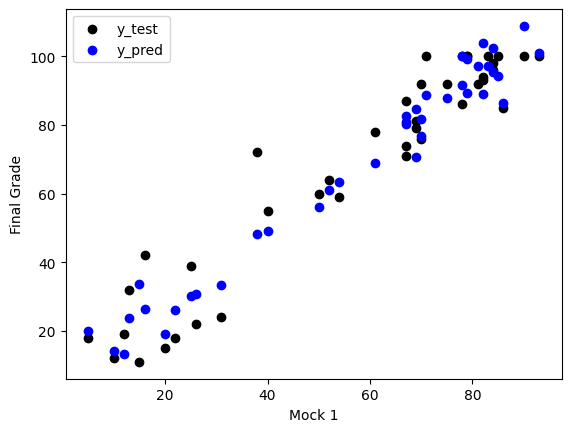

Mean squared error loss: 72.8426
R2 score: 0.9237


In [63]:
from sklearn.impute import SimpleImputer

# Load the data
testData = pd.read_csv('T4-Dataset-3.csv')

# Save it to a pandas dataframe
tar = 'finalGrade'

# create an object of the LabelEncoder class
lblEncoder_X = LabelEncoder()

# Impute missing values for numeric columns with mean
numeric_cols = testData.select_dtypes(include=[np.number]).columns

#Below are the differnt approaches you could use for a numeric column - try uncommenting the others to see their impact.
numeric_imputer = SimpleImputer(strategy='mean')
#numeric_imputer = SimpleImputer(strategy='most_frequent')
#numeric_imputer = SimpleImputer(strategy='median')
#numeric_imputer = SimpleImputer(strategy='constant', fill_value = 0) # try messing around with other constant values!

testData[numeric_cols] = numeric_imputer.fit_transform(testData[numeric_cols])

# Impute missing values for categorical columns with mode
categorical_cols = testData.select_dtypes(include=['object']).columns


# Below are the differnt approaches you could use for a categorical column
categorical_imputer = SimpleImputer(strategy='most_frequent')
  # Blanketly applying the constant this way means that all columns will have the same value imputed
  # If you wanted to do anythin other than make a group for missing categories like
  # I have done, you would have to start appling the constant imputation to
  # individual columns so you can manually set what you want done for each feature.
#categorical_imputer = SimpleImputer(strategy='constant', fill_value = 'Missing')

testData[categorical_cols] = categorical_imputer.fit_transform(testData[categorical_cols])

# Encode our categorical columns
testData['studyTime'] = lblEncoder_X.fit_transform(testData['studyTime'])
testData['travelTime'] = lblEncoder_X.fit_transform(testData['travelTime'])
testData['absence'] = lblEncoder_X.fit_transform(testData['absence'])
testData['school'] = lblEncoder_X.fit_transform(testData['school'])

col_fin = ['mock1', 'mock2', 'studyTime', 'travelTime', 'absence', 'school']

X = np.array(testData[col_fin])
y = np.array(testData[tar])

# Define how much test and training data we want. You can try changing these later to see how it changes the model and predictions
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=0)

# Create linear regression object
obj = sklearn.linear_model.LinearRegression()

# Train the model using the training sets
obj.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = obj.predict(X_test)

X_test_disp = X_test[:, 0]  # We will need to make a special vector for the feature we want on the x axis, as now X is a matrix matplotlib can't use it for a scatter plot

# Plot outputs
plt.scatter(X_test_disp, y_test, color='black', label='y_test')  # Observed y values
plt.scatter(X_test_disp, y_pred, color='blue', label='y_pred')  # Predicted y values
plt.xlabel('Mock 1')
plt.ylabel('Final Grade')
plt.legend()
plt.show()

# The mean squared error loss
print('Mean squared error loss: {:.4f}'.format(sklearn.metrics.mean_squared_error(y_test, y_pred)))
# The R2 score: 1 is perfect prediction
print('R2 score: {:.4f}'.format(sklearn.metrics.r2_score(y_test, y_pred)))
